# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-05-31 16:28:14,324 fedbiomed INFO - Component environment:
2022-05-31 16:28:14,325 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-05-31 16:28:14,662 fedbiomed INFO - Messaging researcher_b17b28ca-9484-4590-ac13-70580f434ba1 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x1375109d0>
2022-05-31 16:28:14,699 fedbiomed INFO - Listing available datasets in all nodes... 
2022-05-31 16:28:24,727 fedbiomed INFO - 
 Node: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a | Number of Datasets: 1 
+---------+-------------+--------------------------+-----------------+--------------------+
| name    | data_type   | tags                     | description     | shape              |
+=========+=============+==========================+=================+====================+
| MEDNIST | mednist     | ['#MEDNIST', '#dataset'] | MEDNIST dataset | [58954, 3, 64, 64] |
+---------+-------------+--------------------------+-----------------+---------

{'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a': [{'name': 'MEDNIST',
   'data_type': 'mednist',
   'tags': ['#MEDNIST', '#dataset'],
   'description': 'MEDNIST dataset',
   'shape': [58954, 3, 64, 64]}],
 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f': [{'name': 'MEDNIST',
   'data_type': 'mednist',
   'tags': ['#MEDNIST', '#dataset'],
   'description': 'MEDNIST dataset',
   'shape': [58954, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [4]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List

#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import monai",
                "from torch.nn import MSELoss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from opacus.validators import ModuleValidator"]
        self.add_dependency(deps)
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
            
    def make_optimizer(self,lr):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict, transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl, batch_size=batch_size, shuffle=True, num_workers=0)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [6]:
model_args = {'use_gpu': True}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 4, 
    'dry_run': False,  
    #'batch_maxnum':10 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MEDNIST', '#dataset']
rounds = 5

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [7]:
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-31 16:28:26,790 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
05/31/2022 16:28:26:INFO:Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2022-05-31 16:28:36,797 fedbiomed INFO - Node selected for training -> node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
05/31/2022 16:28:36:INFO:Node selected for training -> node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
2022-05-31 16:28:36,799 fedbiomed INFO - Node selected for training -> node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
05/31/2022 16:28:36:INFO:Node selected for training -> node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
2022-05-31 16:28:36,802 fedbiomed INFO - Checking data quality of federated datasets...
05/31/2022 16:28:36:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("m

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [8]:
exp.run()

2022-05-31 16:28:37,307 fedbiomed INFO - Sampled nodes in round 0 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
05/31/2022 16:28:37:INFO:Sampled nodes in round 0 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
2022-05-31 16:28:37,309 fedbiomed INFO - Sending request 
					 To: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'a448d87b-c5c2-45b2-b27c-44082ebbeb3c', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/31/my_model_a19ccbba-464d-40fa-89da-7b666fa58ba9.py', 'params_url': 'http://loc

2022-05-31 16:28:55,343 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 16:28:55:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 16:29:01,768 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.056438 
					 ---------
05/31/2022 16:29:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.056438 
					 ---------
2022-05-31 16:29:01,923 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss:

05/31/2022 16:30:11:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1600/7999 (20%) 
 					 Loss: 0.042297 
					 ---------
2022-05-31 16:30:20,881 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.045737 
					 ---------
05/31/2022 16:30:20:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.045737 
					 ---------
2022-05-31 16:30:21,352 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.059772 
					 ---------
05/31/2022 16:30:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.059772 
					 ---------
2022-05-31 16:30:28,020 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:31:39,391 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.047546 
					 ---------
05/31/2022 16:31:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.047546 
					 ---------
2022-05-31 16:31:39,903 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.039645 
					 ---------
05/31/2022 16:31:39:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.039645 
					 ---------
2022-05-31 16:31:51,470 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3520/7999 (44%) 
 					 Loss: 0.045623 
					 ---------
05/31/2022 16:31:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:33:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.051556 
					 ---------
2022-05-31 16:33:12,275 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.039857 
					 ---------
05/31/2022 16:33:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.039857 
					 ---------
2022-05-31 16:33:19,812 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.044769 
					 ---------
05/31/2022 16:33:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.044769 
					 ---------
2022-05-31 16:33:21,495 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:34:22,974 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.033193 
					 ---------
05/31/2022 16:34:22:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.033193 
					 ---------
2022-05-31 16:34:27,790 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.040890 
					 ---------
05/31/2022 16:34:27:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.040890 
					 ---------
2022-05-31 16:34:29,277 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.034259 
					 ---------
05/31/2022 16:34:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:35:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 160/7999 (2%) 
 					 Loss: 0.033499 
					 ---------
2022-05-31 16:36:03,489 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.044983 
					 ---------
05/31/2022 16:36:03:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.044983 
					 ---------
2022-05-31 16:36:08,370 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.032801 
					 ---------
05/31/2022 16:36:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.032801 
					 ---------
2022-05-31 16:36:17,239 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-05-31 16:37:59,434 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.032842 
					 ---------
05/31/2022 16:37:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.032842 
					 ---------
2022-05-31 16:38:02,909 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.032846 
					 ---------
05/31/2022 16:38:02:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.032846 
					 ---------
2022-05-31 16:38:09,347 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2080/7999 (26%) 
 					 Loss: 0.046407 
					 ---------
05/31/2022 16:38:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:39:24:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.038735 
					 ---------
2022-05-31 16:39:26,097 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.038350 
					 ---------
05/31/2022 16:39:26:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.038350 
					 ---------
2022-05-31 16:39:29,704 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.034917 
					 ---------
05/31/2022 16:39:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.034917 
					 ---------
2022-05-31 16:39:31,335 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:40:16,544 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.032212 
					 ---------
05/31/2022 16:40:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.032212 
					 ---------
2022-05-31 16:40:23,354 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.035480 
					 ---------
05/31/2022 16:40:23:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.035480 
					 ---------
2022-05-31 16:40:26,264 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.032766 
					 ---------
05/31/2022 16:40:26:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:41:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6720/7999 (84%) 
 					 Loss: 0.027469 
					 ---------
2022-05-31 16:41:40,147 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.029845 
					 ---------
05/31/2022 16:41:40:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.029845 
					 ---------
2022-05-31 16:41:41,471 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.030854 
					 ---------
05/31/2022 16:41:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.030854 
					 ---------
2022-05-31 16:41:43,380 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:42:12,901 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.024058 
					 ---------
05/31/2022 16:42:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.024058 
					 ---------
2022-05-31 16:42:14,611 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.033330 
					 ---------
05/31/2022 16:42:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.033330 
					 ---------
2022-05-31 16:42:17,032 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 640/7999 (8%) 
 					 Loss: 0.029237 
					 ---------
05/31/2022 16:42:17:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 16:42:47:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.024609 
					 ---------
2022-05-31 16:42:49,353 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.029721 
					 ---------
05/31/2022 16:42:49:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.029721 
					 ---------
2022-05-31 16:42:51,054 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.029428 
					 ---------
05/31/2022 16:42:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.029428 
					 ---------
2022-05-31 16:42:52,505 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:43:20,762 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.025513 
					 ---------
05/31/2022 16:43:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.025513 
					 ---------
2022-05-31 16:43:22,436 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.024703 
					 ---------
05/31/2022 16:43:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.024703 
					 ---------
2022-05-31 16:43:23,980 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.022207 
					 ---------
05/31/2022 16:43:23:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:43:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5280/7999 (66%) 
 					 Loss: 0.017580 
					 ---------
2022-05-31 16:43:53,769 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.022680 
					 ---------
05/31/2022 16:43:53:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.022680 
					 ---------
2022-05-31 16:43:55,249 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.014533 
					 ---------
05/31/2022 16:43:55:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.014533 
					 ---------
2022-05-31 16:43:56,893 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:44:26,957 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.021950 
					 ---------
05/31/2022 16:44:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.021950 
					 ---------
2022-05-31 16:44:28,516 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.017433 
					 ---------
05/31/2022 16:44:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.017433 
					 ---------
2022-05-31 16:44:29,981 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7200/7999 (90%) 
 					 Loss: 0.019756 
					 ---------
05/31/2022 16:44:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:44:57:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.015577 
					 ---------
2022-05-31 16:44:58,915 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.015149 
					 ---------
05/31/2022 16:44:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.015149 
					 ---------
2022-05-31 16:45:00,264 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.019744 
					 ---------
05/31/2022 16:45:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.019744 
					 ---------
2022-05-31 16:45:01,945 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a

2022-05-31 16:45:29,345 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.017180 
					 ---------
05/31/2022 16:45:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.017180 
					 ---------
2022-05-31 16:45:30,532 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.017985 
					 ---------
05/31/2022 16:45:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.017985 
					 ---------
2022-05-31 16:45:32,297 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.017613 
					 ---------
05/31/2022 16:45:32:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:45:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3840/7999 (48%) 
 					 Loss: 0.014660 
					 ---------
2022-05-31 16:46:00,052 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.012654 
					 ---------
05/31/2022 16:46:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.012654 
					 ---------
2022-05-31 16:46:01,839 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.009752 
					 ---------
05/31/2022 16:46:01:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.009752 
					 ---------
2022-05-31 16:46:03,020 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:46:29,999 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.010668 
					 ---------
05/31/2022 16:46:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.010668 
					 ---------
2022-05-31 16:46:31,900 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.013164 
					 ---------
05/31/2022 16:46:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.013164 
					 ---------
2022-05-31 16:46:32,957 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5760/7999 (72%) 
 					 Loss: 0.016530 
					 ---------
05/31/2022 16:46:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:47:03:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.026628 
					 ---------
2022-05-31 16:47:05,381 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.017280 
					 ---------
05/31/2022 16:47:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.017280 
					 ---------
2022-05-31 16:47:06,508 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.018222 
					 ---------
05/31/2022 16:47:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.018222 
					 ---------
2022-05-31 16:47:08,815 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:47:28,658 fedbiomed INFO - Sampled nodes in round 1 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
05/31/2022 16:47:28:INFO:Sampled nodes in round 1 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
2022-05-31 16:47:28,660 fedbiomed INFO - Sending request 
					 To: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'a448d87b-c5c2-45b2-b27c-44082ebbeb3c', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/31/my_model_a19ccbba-464d-40fa-89da-7b666fa58ba9.py', 'params_url': 'http://loc

2022-05-31 16:47:39,035 fedbiomed INFO - WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 16:47:39:INFO:WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 16:47:42,548 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.019377 
					 ---------
05/31/2022 16:47:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.019377 
					 ---------
2022-05-31 16:47:42,550 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss:

05/31/2022 16:48:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1600/7999 (20%) 
 					 Loss: 0.022094 
					 ---------
2022-05-31 16:48:17,532 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.017463 
					 ---------
05/31/2022 16:48:17:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.017463 
					 ---------
2022-05-31 16:48:17,658 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.013182 
					 ---------
05/31/2022 16:48:17:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.013182 
					 ---------
2022-05-31 16:48:21,317 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:48:54,163 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.011219 
					 ---------
05/31/2022 16:48:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.011219 
					 ---------
2022-05-31 16:48:54,388 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.017194 
					 ---------
05/31/2022 16:48:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.017194 
					 ---------
2022-05-31 16:48:57,352 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3520/7999 (44%) 
 					 Loss: 0.012951 
					 ---------
05/31/2022 16:48:57:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:49:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.009826 
					 ---------
2022-05-31 16:49:28,711 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.011020 
					 ---------
05/31/2022 16:49:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.011020 
					 ---------
2022-05-31 16:49:31,981 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.013351 
					 ---------
05/31/2022 16:49:31:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.013351 
					 ---------
2022-05-31 16:49:32,320 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:50:01,948 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.012282 
					 ---------
05/31/2022 16:50:01:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.012282 
					 ---------
2022-05-31 16:50:04,751 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.015812 
					 ---------
05/31/2022 16:50:04:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.015812 
					 ---------
2022-05-31 16:50:05,224 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.015237 
					 ---------
05/31/2022 16:50:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:50:39:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 160/7999 (2%) 
 					 Loss: 0.013065 
					 ---------
2022-05-31 16:50:42,002 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.010590 
					 ---------
05/31/2022 16:50:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.010590 
					 ---------
2022-05-31 16:50:42,484 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.009945 
					 ---------
05/31/2022 16:50:42:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.009945 
					 ---------
2022-05-31 16:50:45,175 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-05-31 16:51:12,135 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.010467 
					 ---------
05/31/2022 16:51:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.010467 
					 ---------
2022-05-31 16:51:12,751 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.016093 
					 ---------
05/31/2022 16:51:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.016093 
					 ---------
2022-05-31 16:51:15,097 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2080/7999 (26%) 
 					 Loss: 0.017270 
					 ---------
05/31/2022 16:51:15:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:51:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.016194 
					 ---------
2022-05-31 16:51:45,423 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.015373 
					 ---------
05/31/2022 16:51:45:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.015373 
					 ---------
2022-05-31 16:51:47,960 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.013761 
					 ---------
05/31/2022 16:51:47:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.013761 
					 ---------
2022-05-31 16:51:48,736 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:52:15,397 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.007824 
					 ---------
05/31/2022 16:52:15:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.007824 
					 ---------
2022-05-31 16:52:17,556 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.018935 
					 ---------
05/31/2022 16:52:17:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.018935 
					 ---------
2022-05-31 16:52:18,331 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.012050 
					 ---------
05/31/2022 16:52:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:52:45:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6720/7999 (84%) 
 					 Loss: 0.011106 
					 ---------
2022-05-31 16:52:47,182 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.019750 
					 ---------
05/31/2022 16:52:47:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.019750 
					 ---------
2022-05-31 16:52:48,052 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.012937 
					 ---------
05/31/2022 16:52:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.012937 
					 ---------
2022-05-31 16:52:50,128 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:53:16,376 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.009182 
					 ---------
05/31/2022 16:53:16:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.009182 
					 ---------
2022-05-31 16:53:17,401 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.028286 
					 ---------
05/31/2022 16:53:17:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.028286 
					 ---------
2022-05-31 16:53:19,318 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 640/7999 (8%) 
 					 Loss: 0.010463 
					 ---------
05/31/2022 16:53:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 16:53:46:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.012676 
					 ---------
2022-05-31 16:53:47,195 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.017138 
					 ---------
05/31/2022 16:53:47:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.017138 
					 ---------
2022-05-31 16:53:49,014 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.018430 
					 ---------
05/31/2022 16:53:49:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.018430 
					 ---------
2022-05-31 16:53:50,113 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:54:16,900 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.013934 
					 ---------
05/31/2022 16:54:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.013934 
					 ---------
2022-05-31 16:54:18,736 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.003753 
					 ---------
05/31/2022 16:54:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.003753 
					 ---------
2022-05-31 16:54:20,036 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.010210 
					 ---------
05/31/2022 16:54:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:54:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5280/7999 (66%) 
 					 Loss: 0.011927 
					 ---------
2022-05-31 16:54:50,531 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.009275 
					 ---------
05/31/2022 16:54:50:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.009275 
					 ---------
2022-05-31 16:54:51,891 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.008789 
					 ---------
05/31/2022 16:54:51:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.008789 
					 ---------
2022-05-31 16:54:53,488 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:55:20,042 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.016092 
					 ---------
05/31/2022 16:55:20:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.016092 
					 ---------
2022-05-31 16:55:21,442 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.011444 
					 ---------
05/31/2022 16:55:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.011444 
					 ---------
2022-05-31 16:55:22,952 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7200/7999 (90%) 
 					 Loss: 0.005775 
					 ---------
05/31/2022 16:55:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:55:49:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.008944 
					 ---------
2022-05-31 16:55:51,407 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.016525 
					 ---------
05/31/2022 16:55:51:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.016525 
					 ---------
2022-05-31 16:55:52,864 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.012794 
					 ---------
05/31/2022 16:55:52:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.012794 
					 ---------
2022-05-31 16:55:54,400 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a

2022-05-31 16:56:21,157 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.016195 
					 ---------
05/31/2022 16:56:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.016195 
					 ---------
2022-05-31 16:56:22,474 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.013590 
					 ---------
05/31/2022 16:56:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.013590 
					 ---------
2022-05-31 16:56:24,091 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.010560 
					 ---------
05/31/2022 16:56:24:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 16:56:51:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3840/7999 (48%) 
 					 Loss: 0.019355 
					 ---------
2022-05-31 16:56:52,844 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.012957 
					 ---------
05/31/2022 16:56:52:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.012957 
					 ---------
2022-05-31 16:56:54,565 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.011028 
					 ---------
05/31/2022 16:56:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.011028 
					 ---------
2022-05-31 16:56:55,769 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:57:22,134 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.016269 
					 ---------
05/31/2022 16:57:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.016269 
					 ---------
2022-05-31 16:57:23,916 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.011821 
					 ---------
05/31/2022 16:57:23:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.011821 
					 ---------
2022-05-31 16:57:25,061 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5760/7999 (72%) 
 					 Loss: 0.006439 
					 ---------
05/31/2022 16:57:25:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:57:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.008287 
					 ---------
2022-05-31 16:57:53,510 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.011169 
					 ---------
05/31/2022 16:57:53:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.011169 
					 ---------
2022-05-31 16:57:54,632 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.008750 
					 ---------
05/31/2022 16:57:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.008750 
					 ---------
2022-05-31 16:57:56,477 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 16:58:14,495 fedbiomed INFO - Sampled nodes in round 2 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
05/31/2022 16:58:14:INFO:Sampled nodes in round 2 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
2022-05-31 16:58:14,497 fedbiomed INFO - Sending request 
					 To: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'a448d87b-c5c2-45b2-b27c-44082ebbeb3c', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/31/my_model_a19ccbba-464d-40fa-89da-7b666fa58ba9.py', 'params_url': 'http://loc

2022-05-31 16:58:23,900 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 16:58:23:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 16:58:26,539 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.031109 
					 ---------
05/31/2022 16:58:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.031109 
					 ---------
2022-05-31 16:58:26,604 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss:

05/31/2022 16:58:53:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1600/7999 (20%) 
 					 Loss: 0.014253 
					 ---------
2022-05-31 16:58:56,489 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.012674 
					 ---------
05/31/2022 16:58:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.012674 
					 ---------
2022-05-31 16:58:56,679 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.014925 
					 ---------
05/31/2022 16:58:56:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.014925 
					 ---------
2022-05-31 16:58:59,389 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 16:59:25,153 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.008776 
					 ---------
05/31/2022 16:59:25:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.008776 
					 ---------
2022-05-31 16:59:25,448 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.011515 
					 ---------
05/31/2022 16:59:25:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.011515 
					 ---------
2022-05-31 16:59:27,995 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3520/7999 (44%) 
 					 Loss: 0.009661 
					 ---------
05/31/2022 16:59:27:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 16:59:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.017722 
					 ---------
2022-05-31 16:59:54,851 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.008648 
					 ---------
05/31/2022 16:59:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.008648 
					 ---------
2022-05-31 16:59:57,312 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.012868 
					 ---------
05/31/2022 16:59:57:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.012868 
					 ---------
2022-05-31 16:59:57,720 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:00:26,440 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.008964 
					 ---------
05/31/2022 17:00:26:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.008964 
					 ---------
2022-05-31 17:00:29,052 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.008548 
					 ---------
05/31/2022 17:00:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.008548 
					 ---------
2022-05-31 17:00:29,628 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.015519 
					 ---------
05/31/2022 17:00:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:00:56:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 160/7999 (2%) 
 					 Loss: 0.010582 
					 ---------
2022-05-31 17:00:58,596 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.014450 
					 ---------
05/31/2022 17:00:58:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.014450 
					 ---------
2022-05-31 17:00:59,181 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.019302 
					 ---------
05/31/2022 17:00:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.019302 
					 ---------
2022-05-31 17:01:01,468 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-05-31 17:01:27,813 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.013094 
					 ---------
05/31/2022 17:01:27:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.013094 
					 ---------
2022-05-31 17:01:28,530 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.013148 
					 ---------
05/31/2022 17:01:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.013148 
					 ---------
2022-05-31 17:01:30,753 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2080/7999 (26%) 
 					 Loss: 0.020770 
					 ---------
05/31/2022 17:01:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:01:57:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.008604 
					 ---------
2022-05-31 17:01:58,721 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.009868 
					 ---------
05/31/2022 17:01:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.009868 
					 ---------
2022-05-31 17:02:00,879 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.005998 
					 ---------
05/31/2022 17:02:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.005998 
					 ---------
2022-05-31 17:02:01,712 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:02:28,474 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.008036 
					 ---------
05/31/2022 17:02:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.008036 
					 ---------
2022-05-31 17:02:30,466 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.011548 
					 ---------
05/31/2022 17:02:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.011548 
					 ---------
2022-05-31 17:02:31,392 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.010147 
					 ---------
05/31/2022 17:02:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:02:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6720/7999 (84%) 
 					 Loss: 0.018352 
					 ---------
2022-05-31 17:03:00,150 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.010111 
					 ---------
05/31/2022 17:03:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.010111 
					 ---------
2022-05-31 17:03:01,189 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.008156 
					 ---------
05/31/2022 17:03:01:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.008156 
					 ---------
2022-05-31 17:03:03,069 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:03:29,251 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.010016 
					 ---------
05/31/2022 17:03:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.010016 
					 ---------
2022-05-31 17:03:30,389 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.011987 
					 ---------
05/31/2022 17:03:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.011987 
					 ---------
2022-05-31 17:03:32,161 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 640/7999 (8%) 
 					 Loss: 0.014384 
					 ---------
05/31/2022 17:03:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 17:03:58:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.008930 
					 ---------
2022-05-31 17:03:59,938 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.010834 
					 ---------
05/31/2022 17:03:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.010834 
					 ---------
2022-05-31 17:04:01,594 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.009906 
					 ---------
05/31/2022 17:04:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.009906 
					 ---------
2022-05-31 17:04:02,840 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:04:28,825 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.009418 
					 ---------
05/31/2022 17:04:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.009418 
					 ---------
2022-05-31 17:04:30,393 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.011257 
					 ---------
05/31/2022 17:04:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.011257 
					 ---------
2022-05-31 17:04:31,678 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.008661 
					 ---------
05/31/2022 17:04:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:04:57:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5280/7999 (66%) 
 					 Loss: 0.007513 
					 ---------
2022-05-31 17:04:59,394 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.014510 
					 ---------
05/31/2022 17:04:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.014510 
					 ---------
2022-05-31 17:05:00,700 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.012439 
					 ---------
05/31/2022 17:05:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.012439 
					 ---------
2022-05-31 17:05:02,233 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:05:27,819 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.009338 
					 ---------
05/31/2022 17:05:27:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.009338 
					 ---------
2022-05-31 17:05:29,196 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.009279 
					 ---------
05/31/2022 17:05:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.009279 
					 ---------
2022-05-31 17:05:30,676 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7200/7999 (90%) 
 					 Loss: 0.023410 
					 ---------
05/31/2022 17:05:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:05:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.019843 
					 ---------
2022-05-31 17:05:57,996 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.011542 
					 ---------
05/31/2022 17:05:57:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.011542 
					 ---------
2022-05-31 17:05:59,402 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.018125 
					 ---------
05/31/2022 17:05:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.018125 
					 ---------
2022-05-31 17:06:00,941 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a

2022-05-31 17:06:28,113 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.012008 
					 ---------
05/31/2022 17:06:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.012008 
					 ---------
2022-05-31 17:06:29,519 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.007512 
					 ---------
05/31/2022 17:06:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.007512 
					 ---------
2022-05-31 17:06:31,416 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.018191 
					 ---------
05/31/2022 17:06:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:06:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3840/7999 (48%) 
 					 Loss: 0.007908 
					 ---------
2022-05-31 17:07:01,015 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.011985 
					 ---------
05/31/2022 17:07:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.011985 
					 ---------
2022-05-31 17:07:02,860 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.007841 
					 ---------
05/31/2022 17:07:02:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.007841 
					 ---------
2022-05-31 17:07:04,037 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:07:29,737 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.005873 
					 ---------
05/31/2022 17:07:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.005873 
					 ---------
2022-05-31 17:07:31,584 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.008913 
					 ---------
05/31/2022 17:07:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.008913 
					 ---------
2022-05-31 17:07:32,583 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5760/7999 (72%) 
 					 Loss: 0.008450 
					 ---------
05/31/2022 17:07:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:07:58:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.011663 
					 ---------
2022-05-31 17:08:00,653 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.011028 
					 ---------
05/31/2022 17:08:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.011028 
					 ---------
2022-05-31 17:08:01,531 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.010588 
					 ---------
05/31/2022 17:08:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.010588 
					 ---------
2022-05-31 17:08:03,524 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:08:20,668 fedbiomed INFO - Sampled nodes in round 3 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
05/31/2022 17:08:20:INFO:Sampled nodes in round 3 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
2022-05-31 17:08:20,670 fedbiomed INFO - Sending request 
					 To: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'a448d87b-c5c2-45b2-b27c-44082ebbeb3c', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/31/my_model_a19ccbba-464d-40fa-89da-7b666fa58ba9.py', 'params_url': 'http://loc

2022-05-31 17:08:30,243 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 17:08:30:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 17:08:32,941 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.012658 
					 ---------
05/31/2022 17:08:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.012658 
					 ---------
2022-05-31 17:08:32,943 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss:

05/31/2022 17:08:57:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1600/7999 (20%) 
 					 Loss: 0.006276 
					 ---------
2022-05-31 17:09:00,566 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.009783 
					 ---------
05/31/2022 17:09:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.009783 
					 ---------
2022-05-31 17:09:00,594 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.007128 
					 ---------
05/31/2022 17:09:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.007128 
					 ---------
2022-05-31 17:09:03,346 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:09:28,202 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.007913 
					 ---------
05/31/2022 17:09:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.007913 
					 ---------
2022-05-31 17:09:28,274 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.012275 
					 ---------
05/31/2022 17:09:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.012275 
					 ---------
2022-05-31 17:09:30,930 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3520/7999 (44%) 
 					 Loss: 0.007290 
					 ---------
05/31/2022 17:09:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:09:55:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.011307 
					 ---------
2022-05-31 17:09:56,046 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.011518 
					 ---------
05/31/2022 17:09:56:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.011518 
					 ---------
2022-05-31 17:09:58,894 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.005550 
					 ---------
05/31/2022 17:09:58:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.005550 
					 ---------
2022-05-31 17:09:59,065 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:10:24,312 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.012966 
					 ---------
05/31/2022 17:10:24:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.012966 
					 ---------
2022-05-31 17:10:26,831 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.017675 
					 ---------
05/31/2022 17:10:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.017675 
					 ---------
2022-05-31 17:10:27,112 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.007719 
					 ---------
05/31/2022 17:10:27:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:10:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 160/7999 (2%) 
 					 Loss: 0.008128 
					 ---------
2022-05-31 17:10:54,890 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.012351 
					 ---------
05/31/2022 17:10:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.012351 
					 ---------
2022-05-31 17:10:55,316 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.008594 
					 ---------
05/31/2022 17:10:55:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.008594 
					 ---------
2022-05-31 17:10:57,827 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-05-31 17:11:23,473 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.010398 
					 ---------
05/31/2022 17:11:23:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.010398 
					 ---------
2022-05-31 17:11:23,964 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.012422 
					 ---------
05/31/2022 17:11:23:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.012422 
					 ---------
2022-05-31 17:11:26,299 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2080/7999 (26%) 
 					 Loss: 0.007818 
					 ---------
05/31/2022 17:11:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:11:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.006609 
					 ---------
2022-05-31 17:11:52,062 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.012189 
					 ---------
05/31/2022 17:11:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.012189 
					 ---------
2022-05-31 17:11:54,284 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.007444 
					 ---------
05/31/2022 17:11:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.007444 
					 ---------
2022-05-31 17:11:54,839 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:12:20,451 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.009002 
					 ---------
05/31/2022 17:12:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.009002 
					 ---------
2022-05-31 17:12:22,542 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.009262 
					 ---------
05/31/2022 17:12:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.009262 
					 ---------
2022-05-31 17:12:23,247 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.008059 
					 ---------
05/31/2022 17:12:23:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:12:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6720/7999 (84%) 
 					 Loss: 0.013801 
					 ---------
2022-05-31 17:12:50,389 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.009718 
					 ---------
05/31/2022 17:12:50:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.009718 
					 ---------
2022-05-31 17:12:51,229 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.010318 
					 ---------
05/31/2022 17:12:51:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.010318 
					 ---------
2022-05-31 17:12:53,191 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:13:18,680 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.007068 
					 ---------
05/31/2022 17:13:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.007068 
					 ---------
2022-05-31 17:13:19,611 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.008038 
					 ---------
05/31/2022 17:13:19:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.008038 
					 ---------
2022-05-31 17:13:21,472 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 640/7999 (8%) 
 					 Loss: 0.008389 
					 ---------
05/31/2022 17:13:21:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 17:13:46:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.009238 
					 ---------
2022-05-31 17:13:47,264 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.008597 
					 ---------
05/31/2022 17:13:47:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.008597 
					 ---------
2022-05-31 17:13:49,051 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.009369 
					 ---------
05/31/2022 17:13:49:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.009369 
					 ---------
2022-05-31 17:13:50,019 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:14:15,214 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.004894 
					 ---------
05/31/2022 17:14:15:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.004894 
					 ---------
2022-05-31 17:14:16,891 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.014030 
					 ---------
05/31/2022 17:14:16:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.014030 
					 ---------
2022-05-31 17:14:17,956 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.005260 
					 ---------
05/31/2022 17:14:17:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:14:42:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5280/7999 (66%) 
 					 Loss: 0.008084 
					 ---------
2022-05-31 17:14:44,430 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.019561 
					 ---------
05/31/2022 17:14:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.019561 
					 ---------
2022-05-31 17:14:45,600 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.013502 
					 ---------
05/31/2022 17:14:45:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.013502 
					 ---------
2022-05-31 17:14:47,163 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:15:12,249 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.013212 
					 ---------
05/31/2022 17:15:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.013212 
					 ---------
2022-05-31 17:15:13,532 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.005216 
					 ---------
05/31/2022 17:15:13:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.005216 
					 ---------
2022-05-31 17:15:14,996 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7200/7999 (90%) 
 					 Loss: 0.010618 
					 ---------
05/31/2022 17:15:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:15:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.012896 
					 ---------
2022-05-31 17:15:41,338 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.008359 
					 ---------
05/31/2022 17:15:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.008359 
					 ---------
2022-05-31 17:15:42,714 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.008347 
					 ---------
05/31/2022 17:15:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.008347 
					 ---------
2022-05-31 17:15:44,160 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a

2022-05-31 17:16:09,665 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.010804 
					 ---------
05/31/2022 17:16:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.010804 
					 ---------
2022-05-31 17:16:10,935 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.011912 
					 ---------
05/31/2022 17:16:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.011912 
					 ---------
2022-05-31 17:16:12,457 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.009649 
					 ---------
05/31/2022 17:16:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:16:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3840/7999 (48%) 
 					 Loss: 0.013162 
					 ---------
2022-05-31 17:16:39,096 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.008610 
					 ---------
05/31/2022 17:16:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.008610 
					 ---------
2022-05-31 17:16:40,789 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.006015 
					 ---------
05/31/2022 17:16:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.006015 
					 ---------
2022-05-31 17:16:41,950 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:17:07,260 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.007342 
					 ---------
05/31/2022 17:17:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.007342 
					 ---------
2022-05-31 17:17:09,303 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.012157 
					 ---------
05/31/2022 17:17:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.012157 
					 ---------
2022-05-31 17:17:10,353 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5760/7999 (72%) 
 					 Loss: 0.007253 
					 ---------
05/31/2022 17:17:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:17:35:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.007662 
					 ---------
2022-05-31 17:17:37,466 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.006527 
					 ---------
05/31/2022 17:17:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.006527 
					 ---------
2022-05-31 17:17:38,374 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.008966 
					 ---------
05/31/2022 17:17:38:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.008966 
					 ---------
2022-05-31 17:17:40,293 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:18:01,818 fedbiomed INFO - Sampled nodes in round 4 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
05/31/2022 17:18:01:INFO:Sampled nodes in round 4 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
2022-05-31 17:18:01,819 fedbiomed INFO - Sending request 
					 To: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'a448d87b-c5c2-45b2-b27c-44082ebbeb3c', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/31/my_model_a19ccbba-464d-40fa-89da-7b666fa58ba9.py', 'params_url': 'http://loc

2022-05-31 17:18:10,145 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 17:18:10:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 17:18:12,802 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.014148 
					 ---------
05/31/2022 17:18:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss: 0.014148 
					 ---------
2022-05-31 17:18:12,854 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 160/7999 (2%) 
 					 Loss:

05/31/2022 17:18:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1600/7999 (20%) 
 					 Loss: 0.007370 
					 ---------
2022-05-31 17:18:41,315 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.006546 
					 ---------
05/31/2022 17:18:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.006546 
					 ---------
2022-05-31 17:18:41,556 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.007303 
					 ---------
05/31/2022 17:18:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.007303 
					 ---------
2022-05-31 17:18:43,987 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:19:08,188 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.007827 
					 ---------
05/31/2022 17:19:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.007827 
					 ---------
2022-05-31 17:19:08,460 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.006296 
					 ---------
05/31/2022 17:19:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3360/7999 (42%) 
 					 Loss: 0.006296 
					 ---------
2022-05-31 17:19:11,087 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3520/7999 (44%) 
 					 Loss: 0.013890 
					 ---------
05/31/2022 17:19:11:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:19:35:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.006361 
					 ---------
2022-05-31 17:19:35,462 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.006719 
					 ---------
05/31/2022 17:19:35:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.006719 
					 ---------
2022-05-31 17:19:37,847 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.010459 
					 ---------
05/31/2022 17:19:37:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5120/7999 (64%) 
 					 Loss: 0.010459 
					 ---------
2022-05-31 17:19:38,191 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:20:03,098 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.014620 
					 ---------
05/31/2022 17:20:03:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6560/7999 (82%) 
 					 Loss: 0.014620 
					 ---------
2022-05-31 17:20:06,673 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.008792 
					 ---------
05/31/2022 17:20:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.008792 
					 ---------
2022-05-31 17:20:07,425 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6720/7999 (84%) 
 					 Loss: 0.010211 
					 ---------
05/31/2022 17:20:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:20:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 160/7999 (2%) 
 					 Loss: 0.018641 
					 ---------
2022-05-31 17:20:40,101 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.007571 
					 ---------
05/31/2022 17:20:40:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.007571 
					 ---------
2022-05-31 17:20:40,552 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.010240 
					 ---------
05/31/2022 17:20:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 320/7999 (4%) 
 					 Loss: 0.010240 
					 ---------
2022-05-31 17:20:42,986 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-05-31 17:21:08,531 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.008157 
					 ---------
05/31/2022 17:21:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.008157 
					 ---------
2022-05-31 17:21:09,047 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.008813 
					 ---------
05/31/2022 17:21:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1920/7999 (24%) 
 					 Loss: 0.008813 
					 ---------
2022-05-31 17:21:11,365 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2080/7999 (26%) 
 					 Loss: 0.009139 
					 ---------
05/31/2022 17:21:11:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:21:37:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.007767 
					 ---------
2022-05-31 17:21:38,061 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.016871 
					 ---------
05/31/2022 17:21:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.016871 
					 ---------
2022-05-31 17:21:40,434 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.005382 
					 ---------
05/31/2022 17:21:40:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.005382 
					 ---------
2022-05-31 17:21:41,008 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:22:06,932 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.012243 
					 ---------
05/31/2022 17:22:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.012243 
					 ---------
2022-05-31 17:22:09,208 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.014799 
					 ---------
05/31/2022 17:22:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.014799 
					 ---------
2022-05-31 17:22:09,831 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5280/7999 (66%) 
 					 Loss: 0.007113 
					 ---------
05/31/2022 17:22:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:22:36:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6720/7999 (84%) 
 					 Loss: 0.009949 
					 ---------
2022-05-31 17:22:38,443 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.007234 
					 ---------
05/31/2022 17:22:38:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.007234 
					 ---------
2022-05-31 17:22:39,165 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.012054 
					 ---------
05/31/2022 17:22:39:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6880/7999 (86%) 
 					 Loss: 0.012054 
					 ---------
2022-05-31 17:22:41,362 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:23:07,397 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.014501 
					 ---------
05/31/2022 17:23:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.014501 
					 ---------
2022-05-31 17:23:08,170 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.011272 
					 ---------
05/31/2022 17:23:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.011272 
					 ---------
2022-05-31 17:23:10,271 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 640/7999 (8%) 
 					 Loss: 0.011002 
					 ---------
05/31/2022 17:23:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 17:23:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.016302 
					 ---------
2022-05-31 17:23:37,491 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.006694 
					 ---------
05/31/2022 17:23:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.006694 
					 ---------
2022-05-31 17:23:39,657 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.010016 
					 ---------
05/31/2022 17:23:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2240/7999 (28%) 
 					 Loss: 0.010016 
					 ---------
2022-05-31 17:23:40,416 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:24:06,663 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.007242 
					 ---------
05/31/2022 17:24:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3680/7999 (46%) 
 					 Loss: 0.007242 
					 ---------
2022-05-31 17:24:08,761 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.006474 
					 ---------
05/31/2022 17:24:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.006474 
					 ---------
2022-05-31 17:24:09,563 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.007913 
					 ---------
05/31/2022 17:24:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:24:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5280/7999 (66%) 
 					 Loss: 0.007484 
					 ---------
2022-05-31 17:24:39,562 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.008007 
					 ---------
05/31/2022 17:24:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.008007 
					 ---------
2022-05-31 17:24:40,500 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.010058 
					 ---------
05/31/2022 17:24:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (68%) 
 					 Loss: 0.010058 
					 ---------
2022-05-31 17:24:42,660 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:25:09,453 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.007991 
					 ---------
05/31/2022 17:25:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.007991 
					 ---------
2022-05-31 17:25:10,403 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.005423 
					 ---------
05/31/2022 17:25:10:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7040/7999 (88%) 
 					 Loss: 0.005423 
					 ---------
2022-05-31 17:25:12,343 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7200/7999 (90%) 
 					 Loss: 0.011675 
					 ---------
05/31/2022 17:25:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:25:38:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.018943 
					 ---------
2022-05-31 17:25:39,848 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.007729 
					 ---------
05/31/2022 17:25:39:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 640/7999 (8%) 
 					 Loss: 0.007729 
					 ---------
2022-05-31 17:25:41,667 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.013224 
					 ---------
05/31/2022 17:25:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 800/7999 (10%) 
 					 Loss: 0.013224 
					 ---------
2022-05-31 17:25:42,693 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a

2022-05-31 17:26:08,597 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.006365 
					 ---------
05/31/2022 17:26:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2240/7999 (28%) 
 					 Loss: 0.006365 
					 ---------
2022-05-31 17:26:10,371 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.007959 
					 ---------
05/31/2022 17:26:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.007959 
					 ---------
2022-05-31 17:26:11,509 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.009237 
					 ---------
05/31/2022 17:26:11:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:26:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3840/7999 (48%) 
 					 Loss: 0.009479 
					 ---------
2022-05-31 17:26:39,502 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.009296 
					 ---------
05/31/2022 17:26:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.009296 
					 ---------
2022-05-31 17:26:40,778 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.006907 
					 ---------
05/31/2022 17:26:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4000/7999 (50%) 
 					 Loss: 0.006907 
					 ---------
2022-05-31 17:26:42,417 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:27:08,207 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.007735 
					 ---------
05/31/2022 17:27:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.007735 
					 ---------
2022-05-31 17:27:09,511 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.006576 
					 ---------
05/31/2022 17:27:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5600/7999 (70%) 
 					 Loss: 0.006576 
					 ---------
2022-05-31 17:27:11,094 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5760/7999 (72%) 
 					 Loss: 0.004224 
					 ---------
05/31/2022 17:27:11:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:27:37:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.008048 
					 ---------
2022-05-31 17:27:38,597 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.018908 
					 ---------
05/31/2022 17:27:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.018908 
					 ---------
2022-05-31 17:27:40,172 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.010964 
					 ---------
05/31/2022 17:27:40:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7360/7999 (92%) 
 					 Loss: 0.010964 
					 ---------
2022-05-31 17:27:41,488 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

5

# Training with DP

## DP parameters

In order to perform DP training (both local and central) we need to provide to the model and training schemes:
* `clip`: defining the maximal L2 norm of gradients
* `sigma`: defining the strenght of Gaussian noise to be added (either to gradients in case of LDP or to the final local model in case of CDP)

## LDP

### Dimensioning the training parameters with LDP

In [9]:
from fedbiomed.researcher.requests import Requests

req = Requests()
query_nodes = req.list()
# min_dataset_size = 1000 #min([xx[i][0]['shape'][0] for i in xx]) #see training data in model
# tot_dataset_size = 1000*len([xx[i][0]['shape'][0] for i in xx]) #sum([xx[i][0]['shape'][0] for i in xx]) #see training data in model

2022-05-31 17:28:02,857 fedbiomed INFO - Listing available datasets in all nodes... 
05/31/2022 17:28:02:INFO:Listing available datasets in all nodes... 


In [10]:
min_dataset_size = min([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['name'] == 'mednist']) #see training data in model
tot_dataset_size = sum([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['name'] == 'mednist']) #see training data in model

In [11]:
q = training_args['batch_size']/min_dataset_size
sigma = 1.
clip = 1.
delta = .1/min_dataset_size
max_epsilon =1.
max_N = int(1e5)

In [12]:
from fedbiomed.researcher.privacy.rdp_accountant import get_iterations, compute_rdp

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [13]:
max_rounds = N/(training_args['epochs'])

In [14]:
assert training_args['epochs']*rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of FL rounds for ({max_epsilon},{delta})-LDP training is {max_rounds}')
print('The selected number of FL rounds, '+str(rounds)+
      ',implies ('+str(eps_list[training_args['epochs']*rounds-1])+','+str(delta)+',)-LDP')

The maximal number of FL rounds for (1.0,1.6962377446822949e-06)-LDP training is 25000.0
The selected number of FL rounds, 5,implies (0.62491339186282,1.6962377446822949e-06,)-LDP


We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the provided privacy parameters.

## Update training parameters for LDP

In order to perform DP-training we should provide an additional argument to training: the dictionalry `'DP_args'` containing necessary parameters for DP. If we want to perform LDP, we should specify: `'type' : 'local'`.

In [15]:
model_args = {'use_gpu': True}
LDP = {'dp_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
model_args.update(LDP)

## Declare and run the LDP training

In [16]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-31 17:28:45,512 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
05/31/2022 17:28:45:INFO:Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2022-05-31 17:28:55,526 fedbiomed INFO - Node selected for training -> node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
05/31/2022 17:28:55:INFO:Node selected for training -> node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
2022-05-31 17:28:55,528 fedbiomed INFO - Node selected for training -> node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
05/31/2022 17:28:55:INFO:Node selected for training -> node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
2022-05-31 17:28:55,532 fedbiomed INFO - Checking data quality of federated datasets...
05/31/2022 17:28:55:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("m

######################################## Fixing Model ########################################


2022-05-31 17:28:55,779 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_111f851c-d90b-4465-8a3e-1e2fe537d8ae.pt successful, with status code 201
05/31/2022 17:28:55:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_111f851c-d90b-4465-8a3e-1e2fe537d8ae.pt successful, with status code 201


In [17]:
exp_LDP.run()

2022-05-31 17:28:55,827 fedbiomed INFO - Sampled nodes in round 0 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
05/31/2022 17:28:55:INFO:Sampled nodes in round 0 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-05-31 17:28:55,828 fedbiomed INFO - Sending request 
					 To: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'd08718c0-a4ce-414b-98ac-34de418605c8', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/31/my_model_89926b8e-1

05/31/2022 17:29:05:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x140faf370>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-05-31 17:29:05,395 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 17:29:05:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 17:29:09,979 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 270/7

05/31/2022 17:29:50:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2300/7999 (20%) 
 					 Loss: 0.066506 
					 ---------
2022-05-31 17:29:52,007 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1400/7999 (20%) 
 					 Loss: 0.068659 
					 ---------
05/31/2022 17:29:52:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1400/7999 (20%) 
 					 Loss: 0.068659 
					 ---------
2022-05-31 17:29:54,771 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.075223 
					 ---------
05/31/2022 17:29:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.075223 
					 ---------
2022-05-31 17:29:56,544 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:30:41,406 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2400/7999 (40%) 
 					 Loss: 0.068513 
					 ---------
05/31/2022 17:30:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2400/7999 (40%) 
 					 Loss: 0.068513 
					 ---------
2022-05-31 17:30:43,181 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2940/7999 (42%) 
 					 Loss: 0.067207 
					 ---------
05/31/2022 17:30:43:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2940/7999 (42%) 
 					 Loss: 0.067207 
					 ---------
2022-05-31 17:30:46,209 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3990/7999 (42%) 
 					 Loss: 0.059956 
					 ---------
05/31/2022 17:30:46:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:31:27:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5400/7999 (60%) 
 					 Loss: 0.058285 
					 ---------
2022-05-31 17:31:30,608 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5270/7999 (62%) 
 					 Loss: 0.053949 
					 ---------
05/31/2022 17:31:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5270/7999 (62%) 
 					 Loss: 0.053949 
					 ---------
2022-05-31 17:31:31,789 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3100/7999 (62%) 
 					 Loss: 0.070179 
					 ---------
05/31/2022 17:31:31:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3100/7999 (62%) 
 					 Loss: 0.070179 
					 ---------
2022-05-31 17:31:35,695 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:32:17,874 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6150/7999 (82%) 
 					 Loss: 0.065925 
					 ---------
05/31/2022 17:32:17:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6150/7999 (82%) 
 					 Loss: 0.065925 
					 ---------
2022-05-31 17:32:18,165 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4100/7999 (82%) 
 					 Loss: 0.066421 
					 ---------
05/31/2022 17:32:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4100/7999 (82%) 
 					 Loss: 0.066421 
					 ---------
2022-05-31 17:32:22,781 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 10500/7999 (84%) 
 					 Loss: 0.062111 
					 ---------
05/31/2022 17:32:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb

05/31/2022 17:33:03:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 210/7999 (2%) 
 					 Loss: 0.053665 
					 ---------
2022-05-31 17:33:05,659 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 210/7999 (2%) 
 					 Loss: 0.054519 
					 ---------
05/31/2022 17:33:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 210/7999 (2%) 
 					 Loss: 0.054519 
					 ---------
2022-05-31 17:33:08,929 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 280/7999 (4%) 
 					 Loss: 0.068304 
					 ---------
05/31/2022 17:33:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 280/7999 (4%) 
 					 Loss: 0.068304 
					 ---------
2022-05-31 17:33:10,089 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

2022-05-31 17:33:50,665 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1210/7999 (22%) 
 					 Loss: 0.046120 
					 ---------
05/31/2022 17:33:50:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1210/7999 (22%) 
 					 Loss: 0.046120 
					 ---------
2022-05-31 17:33:55,026 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2400/7999 (24%) 
 					 Loss: 0.058059 
					 ---------
05/31/2022 17:33:55:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2400/7999 (24%) 
 					 Loss: 0.058059 
					 ---------
2022-05-31 17:33:55,924 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2160/7999 (24%) 
 					 Loss: 0.050596 
					 ---------
05/31/2022 17:33:55:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:34:40:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3780/7999 (42%) 
 					 Loss: 0.048341 
					 ---------
2022-05-31 17:34:43,583 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1980/7999 (44%) 
 					 Loss: 0.048231 
					 ---------
05/31/2022 17:34:43:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1980/7999 (44%) 
 					 Loss: 0.048231 
					 ---------
2022-05-31 17:34:44,956 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4620/7999 (44%) 
 					 Loss: 0.054670 
					 ---------
05/31/2022 17:34:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4620/7999 (44%) 
 					 Loss: 0.054670 
					 ---------
2022-05-31 17:34:47,645 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:35:30,156 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3840/7999 (64%) 
 					 Loss: 0.053336 
					 ---------
05/31/2022 17:35:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3840/7999 (64%) 
 					 Loss: 0.053336 
					 ---------
2022-05-31 17:35:33,456 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2880/7999 (64%) 
 					 Loss: 0.037986 
					 ---------
05/31/2022 17:35:33:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2880/7999 (64%) 
 					 Loss: 0.037986 
					 ---------
2022-05-31 17:35:34,891 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3960/7999 (66%) 
 					 Loss: 0.066255 
					 ---------
05/31/2022 17:35:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:36:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5040/7999 (84%) 
 					 Loss: 0.050728 
					 ---------
2022-05-31 17:36:21,903 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5460/7999 (84%) 
 					 Loss: 0.051385 
					 ---------
05/31/2022 17:36:21:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5460/7999 (84%) 
 					 Loss: 0.051385 
					 ---------
2022-05-31 17:36:24,023 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 9890/7999 (86%) 
 					 Loss: 0.053876 
					 ---------
05/31/2022 17:36:24:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 9890/7999 (86%) 
 					 Loss: 0.053876 
					 ---------
2022-05-31 17:36:26,163 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:37:11,956 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 300/7999 (4%) 
 					 Loss: 0.039158 
					 ---------
05/31/2022 17:37:11:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 300/7999 (4%) 
 					 Loss: 0.039158 
					 ---------
2022-05-31 17:37:12,120 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.054625 
					 ---------
05/31/2022 17:37:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.054625 
					 ---------
2022-05-31 17:37:16,205 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 420/7999 (6%) 
 					 Loss: 0.043189 
					 ---------
05/31/2022 17:37:16:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 17:38:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2210/7999 (26%) 
 					 Loss: 0.052855 
					 ---------
2022-05-31 17:38:02,269 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.050395 
					 ---------
05/31/2022 17:38:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.050395 
					 ---------
2022-05-31 17:38:05,442 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1680/7999 (28%) 
 					 Loss: 0.044538 
					 ---------
05/31/2022 17:38:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1680/7999 (28%) 
 					 Loss: 0.044538 
					 ---------
2022-05-31 17:38:07,116 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:38:51,633 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2420/7999 (44%) 
 					 Loss: 0.065363 
					 ---------
05/31/2022 17:38:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2420/7999 (44%) 
 					 Loss: 0.065363 
					 ---------
2022-05-31 17:38:53,447 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3600/7999 (48%) 
 					 Loss: 0.056634 
					 ---------
05/31/2022 17:38:53:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3600/7999 (48%) 
 					 Loss: 0.056634 
					 ---------
2022-05-31 17:38:56,805 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2990/7999 (46%) 
 					 Loss: 0.055796 
					 ---------
05/31/2022 17:38:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:39:38:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8000/7999 (64%) 
 					 Loss: 0.050962 
					 ---------
2022-05-31 17:39:40,672 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2040/7999 (68%) 
 					 Loss: 0.046659 
					 ---------
05/31/2022 17:39:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2040/7999 (68%) 
 					 Loss: 0.046659 
					 ---------
2022-05-31 17:39:43,975 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4620/7999 (66%) 
 					 Loss: 0.046140 
					 ---------
05/31/2022 17:39:43:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4620/7999 (66%) 
 					 Loss: 0.046140 
					 ---------
2022-05-31 17:39:45,612 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:40:29,415 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7920/7999 (88%) 
 					 Loss: 0.056201 
					 ---------
05/31/2022 17:40:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7920/7999 (88%) 
 					 Loss: 0.056201 
					 ---------
2022-05-31 17:40:31,365 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6880/7999 (86%) 
 					 Loss: 0.050003 
					 ---------
05/31/2022 17:40:31:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6880/7999 (86%) 
 					 Loss: 0.050003 
					 ---------
2022-05-31 17:40:34,559 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 8100/7999 (90%) 
 					 Loss: 0.051997 
					 ---------
05/31/2022 17:40:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:41:17:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 720/7999 (8%) 
 					 Loss: 0.046040 
					 ---------
2022-05-31 17:41:21,247 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 270/7999 (6%) 
 					 Loss: 0.041162 
					 ---------
05/31/2022 17:41:21:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 270/7999 (6%) 
 					 Loss: 0.041162 
					 ---------
2022-05-31 17:41:22,336 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 550/7999 (10%) 
 					 Loss: 0.060750 
					 ---------
05/31/2022 17:41:22:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 550/7999 (10%) 
 					 Loss: 0.060750 
					 ---------
2022-05-31 17:41:25,788 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b

2022-05-31 17:42:09,592 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1690/7999 (26%) 
 					 Loss: 0.045340 
					 ---------
05/31/2022 17:42:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1690/7999 (26%) 
 					 Loss: 0.045340 
					 ---------
2022-05-31 17:42:10,500 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2550/7999 (30%) 
 					 Loss: 0.059901 
					 ---------
05/31/2022 17:42:10:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2550/7999 (30%) 
 					 Loss: 0.059901 
					 ---------
2022-05-31 17:42:14,363 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2100/7999 (28%) 
 					 Loss: 0.054231 
					 ---------
05/31/2022 17:42:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:42:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4140/7999 (46%) 
 					 Loss: 0.055897 
					 ---------
2022-05-31 17:43:00,064 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5250/7999 (50%) 
 					 Loss: 0.056884 
					 ---------
05/31/2022 17:43:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5250/7999 (50%) 
 					 Loss: 0.056884 
					 ---------
2022-05-31 17:43:01,099 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (48%) 
 					 Loss: 0.054051 
					 ---------
05/31/2022 17:43:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (48%) 
 					 Loss: 0.054051 
					 ---------
2022-05-31 17:43:05,165 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:43:47,517 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6460/7999 (68%) 
 					 Loss: 0.048128 
					 ---------
05/31/2022 17:43:47:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6460/7999 (68%) 
 					 Loss: 0.048128 
					 ---------
2022-05-31 17:43:48,449 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6650/7999 (70%) 
 					 Loss: 0.050510 
					 ---------
05/31/2022 17:43:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6650/7999 (70%) 
 					 Loss: 0.050510 
					 ---------
2022-05-31 17:43:51,936 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5950/7999 (70%) 
 					 Loss: 0.049812 
					 ---------
05/31/2022 17:43:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:44:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 8100/7999 (90%) 
 					 Loss: 0.056785 
					 ---------
2022-05-31 17:44:34,469 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 8800/7999 (88%) 
 					 Loss: 0.056151 
					 ---------
05/31/2022 17:44:34:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 8800/7999 (88%) 
 					 Loss: 0.056151 
					 ---------
2022-05-31 17:44:38,821 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 9200/7999 (92%) 
 					 Loss: 0.053800 
					 ---------
05/31/2022 17:44:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 9200/7999 (92%) 
 					 Loss: 0.053800 
					 ---------
2022-05-31 17:44:38,926 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:45:12,435 fedbiomed INFO - Saved aggregated params for round 0 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_6facf50c-57a1-4c73-9097-4346c5175dd8.pt
05/31/2022 17:45:12:INFO:Saved aggregated params for round 0 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_6facf50c-57a1-4c73-9097-4346c5175dd8.pt
2022-05-31 17:45:12,437 fedbiomed INFO - Sampled nodes in round 1 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
05/31/2022 17:45:12:INFO:Sampled nodes in round 1 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-05-31 17:45:12,438 fedbiomed INFO - Sending request 
					 To: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'd08718c0-a4ce-414b-98ac-34de418605c8', 'training_args': {'t

2022-05-31 17:45:22,057 fedbiomed INFO - INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x140fd1f70>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
05/31/2022 17:45:22:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x140fd1f70>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-05-31 17:45:22,072 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-------------------------------

05/31/2022 17:46:04:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1620/7999 (18%) 
 					 Loss: 0.048906 
					 ---------
2022-05-31 17:46:06,770 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 600/7999 (20%) 
 					 Loss: 0.054923 
					 ---------
05/31/2022 17:46:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 600/7999 (20%) 
 					 Loss: 0.054923 
					 ---------
2022-05-31 17:46:09,352 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1000/7999 (20%) 
 					 Loss: 0.051085 
					 ---------
05/31/2022 17:46:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1000/7999 (20%) 
 					 Loss: 0.051085 
					 ---------
2022-05-31 17:46:11,721 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-

2022-05-31 17:46:52,822 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2800/7999 (40%) 
 					 Loss: 0.056337 
					 ---------
05/31/2022 17:46:52:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2800/7999 (40%) 
 					 Loss: 0.056337 
					 ---------
2022-05-31 17:46:55,665 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3000/7999 (40%) 
 					 Loss: 0.047446 
					 ---------
05/31/2022 17:46:55:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3000/7999 (40%) 
 					 Loss: 0.047446 
					 ---------
2022-05-31 17:46:56,780 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3990/7999 (42%) 
 					 Loss: 0.048136 
					 ---------
05/31/2022 17:46:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:47:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3770/7999 (58%) 
 					 Loss: 0.052506 
					 ---------
2022-05-31 17:47:41,295 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3410/7999 (62%) 
 					 Loss: 0.043852 
					 ---------
05/31/2022 17:47:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3410/7999 (62%) 
 					 Loss: 0.043852 
					 ---------
2022-05-31 17:47:42,035 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3900/7999 (60%) 
 					 Loss: 0.044737 
					 ---------
05/31/2022 17:47:42:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3900/7999 (60%) 
 					 Loss: 0.044737 
					 ---------
2022-05-31 17:47:45,696 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:48:29,082 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 7790/7999 (82%) 
 					 Loss: 0.043449 
					 ---------
05/31/2022 17:48:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 7790/7999 (82%) 
 					 Loss: 0.043449 
					 ---------
2022-05-31 17:48:30,345 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (80%) 
 					 Loss: 0.050901 
					 ---------
05/31/2022 17:48:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (80%) 
 					 Loss: 0.050901 
					 ---------
2022-05-31 17:48:33,979 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5880/7999 (84%) 
 					 Loss: 0.061572 
					 ---------
05/31/2022 17:48:33:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:49:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 250/7999 (2%) 
 					 Loss: 0.054637 
					 ---------
2022-05-31 17:49:20,177 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8000/7999 (100%) 
 					 Loss: 0.048892 
					 ---------
05/31/2022 17:49:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8000/7999 (100%) 
 					 Loss: 0.048892 
					 ---------
2022-05-31 17:49:23,716 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 240/7999 (4%) 
 					 Loss: 0.055347 
					 ---------
05/31/2022 17:49:23:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 240/7999 (4%) 
 					 Loss: 0.055347 
					 ---------
2022-05-31 17:49:25,140 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4e

2022-05-31 17:50:09,185 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1300/7999 (20%) 
 					 Loss: 0.060220 
					 ---------
05/31/2022 17:50:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1300/7999 (20%) 
 					 Loss: 0.060220 
					 ---------
2022-05-31 17:50:13,693 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2880/7999 (24%) 
 					 Loss: 0.045625 
					 ---------
05/31/2022 17:50:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2880/7999 (24%) 
 					 Loss: 0.045625 
					 ---------
2022-05-31 17:50:14,848 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1430/7999 (22%) 
 					 Loss: 0.055732 
					 ---------
05/31/2022 17:50:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:51:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3600/7999 (40%) 
 					 Loss: 0.055753 
					 ---------
2022-05-31 17:51:04,242 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.046668 
					 ---------
05/31/2022 17:51:04:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.046668 
					 ---------
2022-05-31 17:51:05,180 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (42%) 
 					 Loss: 0.038693 
					 ---------
05/31/2022 17:51:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (42%) 
 					 Loss: 0.038693 
					 ---------
2022-05-31 17:51:09,052 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:51:54,570 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.057780 
					 ---------
05/31/2022 17:51:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.057780 
					 ---------
2022-05-31 17:51:55,010 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2480/7999 (62%) 
 					 Loss: 0.050342 
					 ---------
05/31/2022 17:51:55:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2480/7999 (62%) 
 					 Loss: 0.050342 
					 ---------
2022-05-31 17:51:59,937 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6270/7999 (66%) 
 					 Loss: 0.045115 
					 ---------
05/31/2022 17:51:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:52:43:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6720/7999 (84%) 
 					 Loss: 0.047078 
					 ---------
2022-05-31 17:52:45,365 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6970/7999 (82%) 
 					 Loss: 0.048661 
					 ---------
05/31/2022 17:52:45:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6970/7999 (82%) 
 					 Loss: 0.048661 
					 ---------
2022-05-31 17:52:48,454 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6020/7999 (86%) 
 					 Loss: 0.058964 
					 ---------
05/31/2022 17:52:48:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6020/7999 (86%) 
 					 Loss: 0.058964 
					 ---------
2022-05-31 17:52:50,635 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:53:34,144 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 180/7999 (2%) 
 					 Loss: 0.052136 
					 ---------
05/31/2022 17:53:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 180/7999 (2%) 
 					 Loss: 0.052136 
					 ---------
2022-05-31 17:53:34,522 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 390/7999 (6%) 
 					 Loss: 0.044489 
					 ---------
05/31/2022 17:53:34:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 390/7999 (6%) 
 					 Loss: 0.044489 
					 ---------
2022-05-31 17:53:38,530 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 280/7999 (4%) 
 					 Loss: 0.055439 
					 ---------
05/31/2022 17:53:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

05/31/2022 17:54:20:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1300/7999 (26%) 
 					 Loss: 0.046069 
					 ---------
2022-05-31 17:54:22,679 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1980/7999 (22%) 
 					 Loss: 0.048026 
					 ---------
05/31/2022 17:54:22:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1980/7999 (22%) 
 					 Loss: 0.048026 
					 ---------
2022-05-31 17:54:25,230 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1960/7999 (28%) 
 					 Loss: 0.059643 
					 ---------
05/31/2022 17:54:25:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1960/7999 (28%) 
 					 Loss: 0.059643 
					 ---------
2022-05-31 17:54:27,297 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 17:55:13,200 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5460/7999 (42%) 
 					 Loss: 0.049214 
					 ---------
05/31/2022 17:55:13:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5460/7999 (42%) 
 					 Loss: 0.049214 
					 ---------
2022-05-31 17:55:13,565 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4080/7999 (48%) 
 					 Loss: 0.049043 
					 ---------
05/31/2022 17:55:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4080/7999 (48%) 
 					 Loss: 0.049043 
					 ---------
2022-05-31 17:55:18,046 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1500/7999 (50%) 
 					 Loss: 0.047289 
					 ---------
05/31/2022 17:55:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:55:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2480/7999 (62%) 
 					 Loss: 0.056402 
					 ---------
2022-05-31 17:56:01,078 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7140/7999 (68%) 
 					 Loss: 0.051391 
					 ---------
05/31/2022 17:56:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7140/7999 (68%) 
 					 Loss: 0.051391 
					 ---------
2022-05-31 17:56:04,054 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5760/7999 (64%) 
 					 Loss: 0.048992 
					 ---------
05/31/2022 17:56:04:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5760/7999 (64%) 
 					 Loss: 0.048992 
					 ---------
2022-05-31 17:56:05,769 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 17:56:47,377 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5720/7999 (88%) 
 					 Loss: 0.047804 
					 ---------
05/31/2022 17:56:47:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5720/7999 (88%) 
 					 Loss: 0.047804 
					 ---------
2022-05-31 17:56:52,177 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8550/7999 (90%) 
 					 Loss: 0.049928 
					 ---------
05/31/2022 17:56:52:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8550/7999 (90%) 
 					 Loss: 0.049928 
					 ---------
2022-05-31 17:56:52,322 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7980/7999 (84%) 
 					 Loss: 0.057396 
					 ---------
05/31/2022 17:56:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 17:57:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 170/7999 (2%) 
 					 Loss: 0.047532 
					 ---------
2022-05-31 17:57:42,270 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 500/7999 (10%) 
 					 Loss: 0.041382 
					 ---------
05/31/2022 17:57:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 500/7999 (10%) 
 					 Loss: 0.041382 
					 ---------
2022-05-31 17:57:42,984 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 280/7999 (4%) 
 					 Loss: 0.047850 
					 ---------
05/31/2022 17:57:42:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 280/7999 (4%) 
 					 Loss: 0.047850 
					 ---------
2022-05-31 17:57:47,397 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b

2022-05-31 17:58:37,787 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.040828 
					 ---------
05/31/2022 17:58:37:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.040828 
					 ---------
2022-05-31 17:58:41,166 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1560/7999 (24%) 
 					 Loss: 0.049154 
					 ---------
05/31/2022 17:58:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1560/7999 (24%) 
 					 Loss: 0.049154 
					 ---------
2022-05-31 17:58:43,655 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2720/7999 (32%) 
 					 Loss: 0.054700 
					 ---------
05/31/2022 17:58:43:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 17:59:32:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1890/7999 (42%) 
 					 Loss: 0.038620 
					 ---------
2022-05-31 17:59:37,640 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4420/7999 (52%) 
 					 Loss: 0.052962 
					 ---------
05/31/2022 17:59:37:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4420/7999 (52%) 
 					 Loss: 0.052962 
					 ---------
2022-05-31 17:59:37,917 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3300/7999 (44%) 
 					 Loss: 0.048796 
					 ---------
05/31/2022 17:59:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3300/7999 (44%) 
 					 Loss: 0.048796 
					 ---------
2022-05-31 17:59:42,744 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:00:35,121 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4480/7999 (64%) 
 					 Loss: 0.057070 
					 ---------
05/31/2022 18:00:35:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4480/7999 (64%) 
 					 Loss: 0.057070 
					 ---------
2022-05-31 18:00:36,301 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5040/7999 (72%) 
 					 Loss: 0.050235 
					 ---------
05/31/2022 18:00:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5040/7999 (72%) 
 					 Loss: 0.050235 
					 ---------
2022-05-31 18:00:40,871 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5610/7999 (66%) 
 					 Loss: 0.050883 
					 ---------
05/31/2022 18:00:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:01:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6720/7999 (84%) 
 					 Loss: 0.051584 
					 ---------
2022-05-31 18:01:30,437 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 9200/7999 (92%) 
 					 Loss: 0.046409 
					 ---------
05/31/2022 18:01:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 9200/7999 (92%) 
 					 Loss: 0.046409 
					 ---------
2022-05-31 18:01:34,793 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 9460/7999 (86%) 
 					 Loss: 0.050826 
					 ---------
05/31/2022 18:01:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 9460/7999 (86%) 
 					 Loss: 0.050826 
					 ---------
2022-05-31 18:01:35,557 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:02:13:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_d2ce7677-da17-41e6-9a2f-bd4ed77c9647.pt successful, with status code 201
2022-05-31 18:02:13,907 fedbiomed INFO - Saved aggregated params for round 1 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_d2ce7677-da17-41e6-9a2f-bd4ed77c9647.pt
05/31/2022 18:02:13:INFO:Saved aggregated params for round 1 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_d2ce7677-da17-41e6-9a2f-bd4ed77c9647.pt
2022-05-31 18:02:13,909 fedbiomed INFO - Sampled nodes in round 2 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
05/31/2022 18:02:13:INFO:Sampled nodes in round 2 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-05-31 18:02:13,911 fedbiomed INFO - Sending request 
					 To: node_4ae95c48-b

05/31/2022 18:02:23:INFO:WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 18:02:23,915 fedbiomed INFO - INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1435761f0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
05/31/2022 18:02:23:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1435761f0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------

05/31/2022 18:03:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1350/7999 (18%) 
 					 Loss: 0.046330 
					 ---------
2022-05-31 18:03:07,726 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1350/7999 (18%) 
 					 Loss: 0.044253 
					 ---------
05/31/2022 18:03:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1350/7999 (18%) 
 					 Loss: 0.044253 
					 ---------
2022-05-31 18:03:12,585 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2100/7999 (20%) 
 					 Loss: 0.048852 
					 ---------
05/31/2022 18:03:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2100/7999 (20%) 
 					 Loss: 0.048852 
					 ---------
2022-05-31 18:03:13,315 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:04:08,131 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3800/7999 (38%) 
 					 Loss: 0.040476 
					 ---------
05/31/2022 18:04:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3800/7999 (38%) 
 					 Loss: 0.040476 
					 ---------
2022-05-31 18:04:12,747 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3600/7999 (40%) 
 					 Loss: 0.048780 
					 ---------
05/31/2022 18:04:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3600/7999 (40%) 
 					 Loss: 0.048780 
					 ---------
2022-05-31 18:04:15,658 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2800/7999 (40%) 
 					 Loss: 0.055266 
					 ---------
05/31/2022 18:04:15:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:05:04:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4640/7999 (58%) 
 					 Loss: 0.048361 
					 ---------
2022-05-31 18:05:08,545 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (60%) 
 					 Loss: 0.055131 
					 ---------
05/31/2022 18:05:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (60%) 
 					 Loss: 0.055131 
					 ---------
2022-05-31 18:05:09,841 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6600/7999 (60%) 
 					 Loss: 0.055137 
					 ---------
05/31/2022 18:05:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6600/7999 (60%) 
 					 Loss: 0.055137 
					 ---------
2022-05-31 18:05:13,579 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:06:07,799 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8400/7999 (80%) 
 					 Loss: 0.048770 
					 ---------
05/31/2022 18:06:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8400/7999 (80%) 
 					 Loss: 0.048770 
					 ---------
2022-05-31 18:06:12,031 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4800/7999 (80%) 
 					 Loss: 0.043184 
					 ---------
05/31/2022 18:06:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4800/7999 (80%) 
 					 Loss: 0.043184 
					 ---------
2022-05-31 18:06:13,166 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5740/7999 (82%) 
 					 Loss: 0.044925 
					 ---------
05/31/2022 18:06:13:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:07:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 7350/7999 (98%) 
 					 Loss: 0.044875 
					 ---------
2022-05-31 18:07:07,213 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 190/7999 (2%) 
 					 Loss: 0.045645 
					 ---------
05/31/2022 18:07:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 190/7999 (2%) 
 					 Loss: 0.045645 
					 ---------
2022-05-31 18:07:08,191 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8000/7999 (100%) 
 					 Loss: 0.050453 
					 ---------
05/31/2022 18:07:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8000/7999 (100%) 
 					 Loss: 0.050453 
					 ---------
2022-05-31 18:07:12,433 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-

2022-05-31 18:08:07,066 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1800/7999 (20%) 
 					 Loss: 0.046579 
					 ---------
05/31/2022 18:08:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1800/7999 (20%) 
 					 Loss: 0.046579 
					 ---------
2022-05-31 18:08:07,562 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1650/7999 (22%) 
 					 Loss: 0.051277 
					 ---------
05/31/2022 18:08:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1650/7999 (22%) 
 					 Loss: 0.051277 
					 ---------
2022-05-31 18:08:14,214 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1870/7999 (22%) 
 					 Loss: 0.048096 
					 ---------
05/31/2022 18:08:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:09:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3570/7999 (42%) 
 					 Loss: 0.050644 
					 ---------
2022-05-31 18:09:06,400 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 800/7999 (40%) 
 					 Loss: 0.060321 
					 ---------
05/31/2022 18:09:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 800/7999 (40%) 
 					 Loss: 0.060321 
					 ---------
2022-05-31 18:09:11,545 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1540/7999 (44%) 
 					 Loss: 0.054836 
					 ---------
05/31/2022 18:09:11:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1540/7999 (44%) 
 					 Loss: 0.054836 
					 ---------
2022-05-31 18:09:12,594 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-

2022-05-31 18:10:04,237 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4800/7999 (60%) 
 					 Loss: 0.040970 
					 ---------
05/31/2022 18:10:04:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4800/7999 (60%) 
 					 Loss: 0.040970 
					 ---------
2022-05-31 18:10:08,543 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5440/7999 (64%) 
 					 Loss: 0.046219 
					 ---------
05/31/2022 18:10:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5440/7999 (64%) 
 					 Loss: 0.046219 
					 ---------
2022-05-31 18:10:09,765 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5270/7999 (62%) 
 					 Loss: 0.043020 
					 ---------
05/31/2022 18:10:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:10:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 8000/7999 (80%) 
 					 Loss: 0.043434 
					 ---------
2022-05-31 18:11:02,915 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7560/7999 (84%) 
 					 Loss: 0.050495 
					 ---------
05/31/2022 18:11:02:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7560/7999 (84%) 
 					 Loss: 0.050495 
					 ---------
2022-05-31 18:11:04,810 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5330/7999 (82%) 
 					 Loss: 0.049063 
					 ---------
05/31/2022 18:11:04:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5330/7999 (82%) 
 					 Loss: 0.049063 
					 ---------
2022-05-31 18:11:07,809 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:12:01,070 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 260/7999 (4%) 
 					 Loss: 0.056775 
					 ---------
05/31/2022 18:12:01:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 260/7999 (4%) 
 					 Loss: 0.056775 
					 ---------
2022-05-31 18:12:01,606 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 170/7999 (2%) 
 					 Loss: 0.054864 
					 ---------
05/31/2022 18:12:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 170/7999 (2%) 
 					 Loss: 0.054864 
					 ---------
2022-05-31 18:12:07,323 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 780/7999 (6%) 
 					 Loss: 0.047686 
					 ---------
05/31/2022 18:12:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

05/31/2022 18:12:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1650/7999 (22%) 
 					 Loss: 0.050301 
					 ---------
2022-05-31 18:13:01,203 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2400/7999 (24%) 
 					 Loss: 0.050648 
					 ---------
05/31/2022 18:13:01:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2400/7999 (24%) 
 					 Loss: 0.050648 
					 ---------
2022-05-31 18:13:05,994 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.049523 
					 ---------
05/31/2022 18:13:05:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.049523 
					 ---------
2022-05-31 18:13:07,654 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:13:58,692 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3080/7999 (44%) 
 					 Loss: 0.042757 
					 ---------
05/31/2022 18:13:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3080/7999 (44%) 
 					 Loss: 0.042757 
					 ---------
2022-05-31 18:14:03,085 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3300/7999 (44%) 
 					 Loss: 0.052961 
					 ---------
05/31/2022 18:14:03:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3300/7999 (44%) 
 					 Loss: 0.052961 
					 ---------
2022-05-31 18:14:04,955 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6210/7999 (46%) 
 					 Loss: 0.050324 
					 ---------
05/31/2022 18:14:04:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:15:13:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6400/7999 (64%) 
 					 Loss: 0.047126 
					 ---------
2022-05-31 18:15:16,720 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3520/7999 (64%) 
 					 Loss: 0.052867 
					 ---------
05/31/2022 18:15:16:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3520/7999 (64%) 
 					 Loss: 0.052867 
					 ---------
2022-05-31 18:15:18,572 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5610/7999 (66%) 
 					 Loss: 0.052445 
					 ---------
05/31/2022 18:15:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5610/7999 (66%) 
 					 Loss: 0.052445 
					 ---------
2022-05-31 18:32:08,005 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:33:49,623 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6720/7999 (84%) 
 					 Loss: 0.046446 
					 ---------
05/31/2022 18:33:49:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6720/7999 (84%) 
 					 Loss: 0.046446 
					 ---------
2022-05-31 18:33:50,842 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4730/7999 (86%) 
 					 Loss: 0.054840 
					 ---------
05/31/2022 18:33:50:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4730/7999 (86%) 
 					 Loss: 0.054840 
					 ---------
2022-05-31 18:33:54,663 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7740/7999 (86%) 
 					 Loss: 0.055040 
					 ---------
05/31/2022 18:33:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:34:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 260/7999 (4%) 
 					 Loss: 0.043055 
					 ---------
2022-05-31 18:34:41,994 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 450/7999 (6%) 
 					 Loss: 0.052184 
					 ---------
05/31/2022 18:34:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 450/7999 (6%) 
 					 Loss: 0.052184 
					 ---------
2022-05-31 18:34:44,058 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 510/7999 (6%) 
 					 Loss: 0.040342 
					 ---------
05/31/2022 18:34:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 510/7999 (6%) 
 					 Loss: 0.040342 
					 ---------
2022-05-31 18:34:46,948 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

2022-05-31 18:35:30,332 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2210/7999 (26%) 
 					 Loss: 0.045623 
					 ---------
05/31/2022 18:35:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2210/7999 (26%) 
 					 Loss: 0.045623 
					 ---------
2022-05-31 18:35:30,416 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1950/7999 (26%) 
 					 Loss: 0.043597 
					 ---------
05/31/2022 18:35:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1950/7999 (26%) 
 					 Loss: 0.043597 
					 ---------
2022-05-31 18:35:34,447 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1960/7999 (28%) 
 					 Loss: 0.043892 
					 ---------
05/31/2022 18:35:34:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:36:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2070/7999 (46%) 
 					 Loss: 0.051713 
					 ---------
2022-05-31 18:36:16,390 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4370/7999 (46%) 
 					 Loss: 0.057637 
					 ---------
05/31/2022 18:36:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4370/7999 (46%) 
 					 Loss: 0.057637 
					 ---------
2022-05-31 18:36:19,405 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4320/7999 (48%) 
 					 Loss: 0.045564 
					 ---------
05/31/2022 18:36:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4320/7999 (48%) 
 					 Loss: 0.045564 
					 ---------
2022-05-31 18:36:20,787 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:37:02,093 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6600/7999 (66%) 
 					 Loss: 0.042699 
					 ---------
05/31/2022 18:37:02:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6600/7999 (66%) 
 					 Loss: 0.042699 
					 ---------
2022-05-31 18:37:05,541 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6460/7999 (68%) 
 					 Loss: 0.052123 
					 ---------
05/31/2022 18:37:05:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6460/7999 (68%) 
 					 Loss: 0.052123 
					 ---------
2022-05-31 18:37:06,643 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4420/7999 (68%) 
 					 Loss: 0.044302 
					 ---------
05/31/2022 18:37:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:37:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7740/7999 (86%) 
 					 Loss: 0.048141 
					 ---------
2022-05-31 18:37:56,765 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4840/7999 (88%) 
 					 Loss: 0.050306 
					 ---------
05/31/2022 18:37:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4840/7999 (88%) 
 					 Loss: 0.050306 
					 ---------
2022-05-31 18:37:57,378 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 9240/7999 (88%) 
 					 Loss: 0.047501 
					 ---------
05/31/2022 18:37:57:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 9240/7999 (88%) 
 					 Loss: 0.047501 
					 ---------
2022-05-31 18:38:01,254 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:38:38,283 fedbiomed INFO - Nodes that successfully reply in round 2 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
05/31/2022 18:38:38:INFO:Nodes that successfully reply in round 2 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
2022-05-31 18:38:38,451 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_4b332677-db26-4019-bf17-ed545ba39639.pt successful, with status code 201
05/31/2022 18:38:38:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_4b332677-db26-4019-bf17-ed545ba39639.pt successful, with status code 201
2022-05-31 18:38:38,453 fedbiomed INFO - Saved aggregated params for round 2 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_4b332677-db26-4019-bf17-ed545ba39639.pt
05/31

2022-05-31 18:38:48,459 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 18:38:48:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 18:38:48,511 fedbiomed INFO - INFO
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x143754100>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
05/31/2022 18:38:48:INFO:INFO
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: training with arguments {'hi

2022-05-31 18:39:34,752 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1440/7999 (18%) 
 					 Loss: 0.044744 
					 ---------
05/31/2022 18:39:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1440/7999 (18%) 
 					 Loss: 0.044744 
					 ---------
2022-05-31 18:39:36,950 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1440/7999 (18%) 
 					 Loss: 0.053848 
					 ---------
05/31/2022 18:39:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1440/7999 (18%) 
 					 Loss: 0.053848 
					 ---------
2022-05-31 18:39:39,681 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1300/7999 (20%) 
 					 Loss: 0.045598 
					 ---------
05/31/2022 18:39:39:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:40:24:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2280/7999 (38%) 
 					 Loss: 0.045379 
					 ---------
2022-05-31 18:40:28,612 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3230/7999 (38%) 
 					 Loss: 0.054337 
					 ---------
05/31/2022 18:40:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3230/7999 (38%) 
 					 Loss: 0.054337 
					 ---------
2022-05-31 18:40:30,002 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3400/7999 (40%) 
 					 Loss: 0.043740 
					 ---------
05/31/2022 18:40:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3400/7999 (40%) 
 					 Loss: 0.043740 
					 ---------
2022-05-31 18:40:33,260 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:41:20,608 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5220/7999 (58%) 
 					 Loss: 0.056887 
					 ---------
05/31/2022 18:41:20:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5220/7999 (58%) 
 					 Loss: 0.056887 
					 ---------
2022-05-31 18:41:21,289 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (60%) 
 					 Loss: 0.044883 
					 ---------
05/31/2022 18:41:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (60%) 
 					 Loss: 0.044883 
					 ---------
2022-05-31 18:41:26,498 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6000/7999 (60%) 
 					 Loss: 0.041616 
					 ---------
05/31/2022 18:41:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:42:10:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6800/7999 (80%) 
 					 Loss: 0.041490 
					 ---------
2022-05-31 18:42:13,408 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8190/7999 (78%) 
 					 Loss: 0.054270 
					 ---------
05/31/2022 18:42:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8190/7999 (78%) 
 					 Loss: 0.054270 
					 ---------
2022-05-31 18:42:15,639 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 7380/7999 (82%) 
 					 Loss: 0.057217 
					 ---------
05/31/2022 18:42:15:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 7380/7999 (82%) 
 					 Loss: 0.057217 
					 ---------
2022-05-31 18:42:18,270 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:43:02,975 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 7840/7999 (98%) 
 					 Loss: 0.051611 
					 ---------
05/31/2022 18:43:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 7840/7999 (98%) 
 					 Loss: 0.051611 
					 ---------
2022-05-31 18:43:06,136 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 160/7999 (2%) 
 					 Loss: 0.040014 
					 ---------
05/31/2022 18:43:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 160/7999 (2%) 
 					 Loss: 0.040014 
					 ---------
2022-05-31 18:43:07,966 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6000/7999 (100%) 
 					 Loss: 0.047262 
					 ---------
05/31/2022 18:43:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4

05/31/2022 18:43:53:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1440/7999 (18%) 
 					 Loss: 0.051486 
					 ---------
2022-05-31 18:43:58,113 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1870/7999 (22%) 
 					 Loss: 0.043404 
					 ---------
05/31/2022 18:43:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1870/7999 (22%) 
 					 Loss: 0.043404 
					 ---------
2022-05-31 18:43:58,401 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1000/7999 (20%) 
 					 Loss: 0.057972 
					 ---------
05/31/2022 18:43:58:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1000/7999 (20%) 
 					 Loss: 0.057972 
					 ---------
2022-05-31 18:44:03,203 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:44:46,671 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3200/7999 (40%) 
 					 Loss: 0.063345 
					 ---------
05/31/2022 18:44:46:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3200/7999 (40%) 
 					 Loss: 0.063345 
					 ---------
2022-05-31 18:44:48,891 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (42%) 
 					 Loss: 0.050457 
					 ---------
05/31/2022 18:44:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (42%) 
 					 Loss: 0.050457 
					 ---------
2022-05-31 18:44:51,846 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2310/7999 (42%) 
 					 Loss: 0.045587 
					 ---------
05/31/2022 18:44:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:45:37:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5700/7999 (60%) 
 					 Loss: 0.031458 
					 ---------
2022-05-31 18:45:38,819 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 4030/7999 (62%) 
 					 Loss: 0.045695 
					 ---------
05/31/2022 18:45:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 4030/7999 (62%) 
 					 Loss: 0.045695 
					 ---------
2022-05-31 18:45:42,636 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 7440/7999 (62%) 
 					 Loss: 0.048094 
					 ---------
05/31/2022 18:45:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 7440/7999 (62%) 
 					 Loss: 0.048094 
					 ---------
2022-05-31 18:45:43,396 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:46:28,216 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5740/7999 (82%) 
 					 Loss: 0.050450 
					 ---------
05/31/2022 18:46:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5740/7999 (82%) 
 					 Loss: 0.050450 
					 ---------
2022-05-31 18:46:31,216 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6560/7999 (82%) 
 					 Loss: 0.054337 
					 ---------
05/31/2022 18:46:31:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6560/7999 (82%) 
 					 Loss: 0.054337 
					 ---------
2022-05-31 18:46:33,068 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7560/7999 (84%) 
 					 Loss: 0.055098 
					 ---------
05/31/2022 18:46:33:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:47:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 120/7999 (2%) 
 					 Loss: 0.053883 
					 ---------
2022-05-31 18:47:19,733 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 130/7999 (2%) 
 					 Loss: 0.042785 
					 ---------
05/31/2022 18:47:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 130/7999 (2%) 
 					 Loss: 0.042785 
					 ---------
2022-05-31 18:47:21,951 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 500/7999 (4%) 
 					 Loss: 0.049301 
					 ---------
05/31/2022 18:47:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 500/7999 (4%) 
 					 Loss: 0.049301 
					 ---------
2022-05-31 18:47:24,622 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 18:48:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2310/7999 (22%) 
 					 Loss: 0.041266 
					 ---------
2022-05-31 18:48:11,660 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2760/7999 (24%) 
 					 Loss: 0.040076 
					 ---------
05/31/2022 18:48:11:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2760/7999 (24%) 
 					 Loss: 0.040076 
					 ---------
2022-05-31 18:48:12,334 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.040175 
					 ---------
05/31/2022 18:48:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.040175 
					 ---------
2022-05-31 18:48:16,743 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:49:00,576 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4400/7999 (44%) 
 					 Loss: 0.043888 
					 ---------
05/31/2022 18:49:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4400/7999 (44%) 
 					 Loss: 0.043888 
					 ---------
2022-05-31 18:49:02,882 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4400/7999 (44%) 
 					 Loss: 0.048731 
					 ---------
05/31/2022 18:49:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4400/7999 (44%) 
 					 Loss: 0.048731 
					 ---------
2022-05-31 18:49:05,232 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2300/7999 (46%) 
 					 Loss: 0.054106 
					 ---------
05/31/2022 18:49:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:49:49:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5440/7999 (64%) 
 					 Loss: 0.053964 
					 ---------
2022-05-31 18:49:51,383 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5120/7999 (64%) 
 					 Loss: 0.033754 
					 ---------
05/31/2022 18:49:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5120/7999 (64%) 
 					 Loss: 0.033754 
					 ---------
2022-05-31 18:49:54,113 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4950/7999 (66%) 
 					 Loss: 0.042928 
					 ---------
05/31/2022 18:49:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4950/7999 (66%) 
 					 Loss: 0.042928 
					 ---------
2022-05-31 18:49:56,568 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:50:39,496 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4620/7999 (84%) 
 					 Loss: 0.050373 
					 ---------
05/31/2022 18:50:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4620/7999 (84%) 
 					 Loss: 0.050373 
					 ---------
2022-05-31 18:50:43,265 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7740/7999 (86%) 
 					 Loss: 0.045583 
					 ---------
05/31/2022 18:50:43:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7740/7999 (86%) 
 					 Loss: 0.045583 
					 ---------
2022-05-31 18:50:44,617 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 9030/7999 (86%) 
 					 Loss: 0.045029 
					 ---------
05/31/2022 18:50:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:51:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 180/7999 (4%) 
 					 Loss: 0.038155 
					 ---------
2022-05-31 18:51:29,368 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 480/7999 (6%) 
 					 Loss: 0.045441 
					 ---------
05/31/2022 18:51:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 480/7999 (6%) 
 					 Loss: 0.045441 
					 ---------
2022-05-31 18:51:32,905 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 660/7999 (6%) 
 					 Loss: 0.045942 
					 ---------
05/31/2022 18:51:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 660/7999 (6%) 
 					 Loss: 0.045942 
					 ---------
2022-05-31 18:51:35,153 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

2022-05-31 18:52:17,724 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (24%) 
 					 Loss: 0.052951 
					 ---------
05/31/2022 18:52:17:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (24%) 
 					 Loss: 0.052951 
					 ---------
2022-05-31 18:52:22,584 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2380/7999 (28%) 
 					 Loss: 0.043639 
					 ---------
05/31/2022 18:52:22:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2380/7999 (28%) 
 					 Loss: 0.043639 
					 ---------
2022-05-31 18:52:22,616 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2340/7999 (26%) 
 					 Loss: 0.039109 
					 ---------
05/31/2022 18:52:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:53:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3910/7999 (46%) 
 					 Loss: 0.050493 
					 ---------
2022-05-31 18:53:11,392 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3680/7999 (46%) 
 					 Loss: 0.051722 
					 ---------
05/31/2022 18:53:11:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3680/7999 (46%) 
 					 Loss: 0.051722 
					 ---------
2022-05-31 18:53:12,637 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4080/7999 (48%) 
 					 Loss: 0.043389 
					 ---------
05/31/2022 18:53:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4080/7999 (48%) 
 					 Loss: 0.043389 
					 ---------
2022-05-31 18:53:15,764 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:54:05,268 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5280/7999 (66%) 
 					 Loss: 0.034962 
					 ---------
05/31/2022 18:54:05:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5280/7999 (66%) 
 					 Loss: 0.034962 
					 ---------
2022-05-31 18:54:06,252 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4420/7999 (68%) 
 					 Loss: 0.054354 
					 ---------
05/31/2022 18:54:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4420/7999 (68%) 
 					 Loss: 0.054354 
					 ---------
2022-05-31 18:54:10,848 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4420/7999 (68%) 
 					 Loss: 0.053140 
					 ---------
05/31/2022 18:54:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:54:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5280/7999 (88%) 
 					 Loss: 0.046134 
					 ---------
2022-05-31 18:54:59,275 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 10750/7999 (86%) 
 					 Loss: 0.046793 
					 ---------
05/31/2022 18:54:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 10750/7999 (86%) 
 					 Loss: 0.046793 
					 ---------
2022-05-31 18:55:05,373 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6300/7999 (90%) 
 					 Loss: 0.042534 
					 ---------
05/31/2022 18:55:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6300/7999 (90%) 
 					 Loss: 0.042534 
					 ---------
2022-05-31 18:55:06,042 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-c

2022-05-31 18:55:44,841 fedbiomed INFO - Nodes that successfully reply in round 3 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
05/31/2022 18:55:44:INFO:Nodes that successfully reply in round 3 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-05-31 18:55:45,041 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_eafcc5a3-3146-4170-ae3f-2efcffa86a1e.pt successful, with status code 201
05/31/2022 18:55:45:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_eafcc5a3-3146-4170-ae3f-2efcffa86a1e.pt successful, with status code 201
2022-05-31 18:55:45,043 fedbiomed INFO - Saved aggregated params for round 3 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_eafcc5a3-3146-4170-ae3f-2efcffa86a1e.pt
05/31

2022-05-31 18:55:54,876 fedbiomed INFO - WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/31/2022 18:55:54:INFO:WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-31 18:55:54,989 fedbiomed INFO - INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x14429bdc0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
05/31/2022 18:55:54:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'hi

2022-05-31 18:56:37,466 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1800/7999 (18%) 
 					 Loss: 0.051603 
					 ---------
05/31/2022 18:56:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1800/7999 (18%) 
 					 Loss: 0.051603 
					 ---------
2022-05-31 18:56:38,372 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2070/7999 (18%) 
 					 Loss: 0.056550 
					 ---------
05/31/2022 18:56:38:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2070/7999 (18%) 
 					 Loss: 0.056550 
					 ---------
2022-05-31 18:56:42,411 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1800/7999 (20%) 
 					 Loss: 0.048304 
					 ---------
05/31/2022 18:56:42:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 18:57:26:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2470/7999 (38%) 
 					 Loss: 0.048263 
					 ---------
2022-05-31 18:57:28,616 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2470/7999 (38%) 
 					 Loss: 0.034510 
					 ---------
05/31/2022 18:57:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2470/7999 (38%) 
 					 Loss: 0.034510 
					 ---------
2022-05-31 18:57:31,411 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3200/7999 (40%) 
 					 Loss: 0.046312 
					 ---------
05/31/2022 18:57:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3200/7999 (40%) 
 					 Loss: 0.046312 
					 ---------
2022-05-31 18:57:33,271 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 18:58:17,186 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4060/7999 (58%) 
 					 Loss: 0.049483 
					 ---------
05/31/2022 18:58:17:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4060/7999 (58%) 
 					 Loss: 0.049483 
					 ---------
2022-05-31 18:58:19,125 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4500/7999 (60%) 
 					 Loss: 0.040939 
					 ---------
05/31/2022 18:58:19:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4500/7999 (60%) 
 					 Loss: 0.040939 
					 ---------
2022-05-31 18:58:22,385 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5400/7999 (60%) 
 					 Loss: 0.045840 
					 ---------
05/31/2022 18:58:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 18:59:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6630/7999 (78%) 
 					 Loss: 0.046601 
					 ---------
2022-05-31 18:59:09,946 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6400/7999 (80%) 
 					 Loss: 0.042078 
					 ---------
05/31/2022 18:59:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6400/7999 (80%) 
 					 Loss: 0.042078 
					 ---------
2022-05-31 18:59:13,575 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8800/7999 (80%) 
 					 Loss: 0.051487 
					 ---------
05/31/2022 18:59:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8800/7999 (80%) 
 					 Loss: 0.051487 
					 ---------
2022-05-31 18:59:14,989 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 18:59:59,751 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 7840/7999 (98%) 
 					 Loss: 0.040284 
					 ---------
05/31/2022 18:59:59:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 7840/7999 (98%) 
 					 Loss: 0.040284 
					 ---------
2022-05-31 19:00:04,120 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 140/7999 (2%) 
 					 Loss: 0.046516 
					 ---------
05/31/2022 19:00:04:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 140/7999 (2%) 
 					 Loss: 0.046516 
					 ---------
2022-05-31 19:00:05,260 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 9500/7999 (100%) 
 					 Loss: 0.052387 
					 ---------
05/31/2022 19:00:05:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4

05/31/2022 19:00:57:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1080/7999 (18%) 
 					 Loss: 0.039366 
					 ---------
2022-05-31 19:00:59,027 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1980/7999 (22%) 
 					 Loss: 0.044982 
					 ---------
05/31/2022 19:00:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1980/7999 (22%) 
 					 Loss: 0.044982 
					 ---------
2022-05-31 19:01:02,563 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1600/7999 (20%) 
 					 Loss: 0.042383 
					 ---------
05/31/2022 19:01:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1600/7999 (20%) 
 					 Loss: 0.042383 
					 ---------
2022-05-31 19:01:04,294 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 19:01:47,629 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5040/7999 (42%) 
 					 Loss: 0.046227 
					 ---------
05/31/2022 19:01:47:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5040/7999 (42%) 
 					 Loss: 0.046227 
					 ---------
2022-05-31 19:01:52,132 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.041116 
					 ---------
05/31/2022 19:01:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.041116 
					 ---------
2022-05-31 19:01:52,371 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3000/7999 (40%) 
 					 Loss: 0.044625 
					 ---------
05/31/2022 19:01:52:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 19:02:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5220/7999 (58%) 
 					 Loss: 0.054237 
					 ---------
2022-05-31 19:02:39,934 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.051419 
					 ---------
05/31/2022 19:02:39:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5120/7999 (64%) 
 					 Loss: 0.051419 
					 ---------
2022-05-31 19:02:41,965 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 7200/7999 (60%) 
 					 Loss: 0.055625 
					 ---------
05/31/2022 19:02:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 7200/7999 (60%) 
 					 Loss: 0.055625 
					 ---------
2022-05-31 19:02:45,060 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 19:03:30,181 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (84%) 
 					 Loss: 0.053187 
					 ---------
05/31/2022 19:03:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (84%) 
 					 Loss: 0.053187 
					 ---------
2022-05-31 19:03:32,107 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 9600/7999 (80%) 
 					 Loss: 0.045900 
					 ---------
05/31/2022 19:03:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 9600/7999 (80%) 
 					 Loss: 0.045900 
					 ---------
2022-05-31 19:03:34,831 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6450/7999 (86%) 
 					 Loss: 0.047965 
					 ---------
05/31/2022 19:03:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 19:04:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 300/7999 (4%) 
 					 Loss: 0.046275 
					 ---------
2022-05-31 19:04:20,415 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 11000/7999 (100%) 
 					 Loss: 0.036814 
					 ---------
05/31/2022 19:04:20:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 11000/7999 (100%) 
 					 Loss: 0.036814 
					 ---------
2022-05-31 19:04:23,249 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 450/7999 (6%) 
 					 Loss: 0.045129 
					 ---------
05/31/2022 19:04:23:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 450/7999 (6%) 
 					 Loss: 0.045129 
					 ---------
2022-05-31 19:04:25,353 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-

2022-05-31 19:05:11,825 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1500/7999 (20%) 
 					 Loss: 0.046164 
					 ---------
05/31/2022 19:05:11:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1500/7999 (20%) 
 					 Loss: 0.046164 
					 ---------
2022-05-31 19:05:14,546 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.039111 
					 ---------
05/31/2022 19:05:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2080/7999 (26%) 
 					 Loss: 0.039111 
					 ---------
2022-05-31 19:05:17,617 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1760/7999 (22%) 
 					 Loss: 0.045750 
					 ---------
05/31/2022 19:05:17:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 19:06:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2600/7999 (40%) 
 					 Loss: 0.047556 
					 ---------
2022-05-31 19:06:08,230 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4370/7999 (46%) 
 					 Loss: 0.049501 
					 ---------
05/31/2022 19:06:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4370/7999 (46%) 
 					 Loss: 0.049501 
					 ---------
2022-05-31 19:06:11,648 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2310/7999 (42%) 
 					 Loss: 0.046422 
					 ---------
05/31/2022 19:06:11:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2310/7999 (42%) 
 					 Loss: 0.046422 
					 ---------
2022-05-31 19:06:13,225 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-05-31 19:06:58,572 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6930/7999 (66%) 
 					 Loss: 0.050562 
					 ---------
05/31/2022 19:06:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6930/7999 (66%) 
 					 Loss: 0.050562 
					 ---------
2022-05-31 19:07:01,619 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5890/7999 (62%) 
 					 Loss: 0.055197 
					 ---------
05/31/2022 19:07:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5890/7999 (62%) 
 					 Loss: 0.055197 
					 ---------
2022-05-31 19:07:03,426 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 8500/7999 (68%) 
 					 Loss: 0.048563 
					 ---------
05/31/2022 19:07:03:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

05/31/2022 19:07:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 10750/7999 (86%) 
 					 Loss: 0.051566 
					 ---------
2022-05-31 19:07:56,093 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8200/7999 (82%) 
 					 Loss: 0.042393 
					 ---------
05/31/2022 19:07:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8200/7999 (82%) 
 					 Loss: 0.042393 
					 ---------
2022-05-31 19:07:57,085 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6600/7999 (88%) 
 					 Loss: 0.041118 
					 ---------
05/31/2022 19:07:57:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6600/7999 (88%) 
 					 Loss: 0.041118 
					 ---------
2022-05-31 19:08:00,867 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb

2022-05-31 19:08:44,554 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 170/7999 (2%) 
 					 Loss: 0.046375 
					 ---------
05/31/2022 19:08:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 170/7999 (2%) 
 					 Loss: 0.046375 
					 ---------
2022-05-31 19:08:45,112 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 480/7999 (8%) 
 					 Loss: 0.037879 
					 ---------
05/31/2022 19:08:45:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 480/7999 (8%) 
 					 Loss: 0.037879 
					 ---------
2022-05-31 19:08:48,721 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 220/7999 (4%) 
 					 Loss: 0.030890 
					 ---------
05/31/2022 19:08:48:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

05/31/2022 19:09:33:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2100/7999 (28%) 
 					 Loss: 0.048111 
					 ---------
2022-05-31 19:09:33,791 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1870/7999 (22%) 
 					 Loss: 0.045689 
					 ---------
05/31/2022 19:09:33:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1870/7999 (22%) 
 					 Loss: 0.045689 
					 ---------
2022-05-31 19:09:37,761 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1800/7999 (30%) 
 					 Loss: 0.061137 
					 ---------
05/31/2022 19:09:37:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1800/7999 (30%) 
 					 Loss: 0.061137 
					 ---------
2022-05-31 19:09:38,804 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 19:10:25,866 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3360/7999 (42%) 
 					 Loss: 0.039295 
					 ---------
05/31/2022 19:10:25:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3360/7999 (42%) 
 					 Loss: 0.039295 
					 ---------
2022-05-31 19:10:30,324 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5000/7999 (50%) 
 					 Loss: 0.043993 
					 ---------
05/31/2022 19:10:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5000/7999 (50%) 
 					 Loss: 0.043993 
					 ---------
2022-05-31 19:10:30,405 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2200/7999 (44%) 
 					 Loss: 0.049793 
					 ---------
05/31/2022 19:10:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 19:11:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6460/7999 (68%) 
 					 Loss: 0.051572 
					 ---------
2022-05-31 19:11:19,026 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4160/7999 (64%) 
 					 Loss: 0.040087 
					 ---------
05/31/2022 19:11:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4160/7999 (64%) 
 					 Loss: 0.040087 
					 ---------
2022-05-31 19:11:19,454 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4900/7999 (70%) 
 					 Loss: 0.040540 
					 ---------
05/31/2022 19:11:19:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4900/7999 (70%) 
 					 Loss: 0.040540 
					 ---------
2022-05-31 19:11:24,031 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-05-31 19:12:09,404 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5880/7999 (84%) 
 					 Loss: 0.037725 
					 ---------
05/31/2022 19:12:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5880/7999 (84%) 
 					 Loss: 0.037725 
					 ---------
2022-05-31 19:12:09,448 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6750/7999 (90%) 
 					 Loss: 0.045084 
					 ---------
05/31/2022 19:12:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6750/7999 (90%) 
 					 Loss: 0.045084 
					 ---------
2022-05-31 19:12:14,620 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6880/7999 (86%) 
 					 Loss: 0.039151 
					 ---------
05/31/2022 19:12:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

05/31/2022 19:12:55:DEBUG:upload (HTTP GET request) of file node_params_0e9f563a-cb28-40cb-bbe0-fdd33ead1fe2.pt successful, with status code 200
2022-05-31 19:12:55,886 fedbiomed INFO - Nodes that successfully reply in round 4 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
05/31/2022 19:12:55:INFO:Nodes that successfully reply in round 4 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-05-31 19:12:56,087 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_cc4d0021-ed20-426d-b11a-7753eb6e79c7.pt successful, with status code 201
05/31/2022 19:12:56:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_cc4d0021-ed20-426d-b11a-7753eb6e79c7.pt successful, with status code 201
2022-05-31 19:12:56,089 fedbiomed INFO - Saved aggregated params fo

5

## CDP

### Dimensioning the training parameters with CDP

In [76]:
import numpy as np
num_clients = len([query_nodes[i][0]['shape'][0] for i in query_nodes])

# Here we use the same parameters as LDP to evaluate the number of rounds, 
# since we are performing record-level DP

q = training_args['batch_size']/min_dataset_size 
sigma = 0.4#/(np.sqrt(num_clients)*training_args['batch_size'])
clip = 0.005
delta = .1/min_dataset_size
max_epsilon = 10.
max_N = int(1e2)

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [77]:
max_rounds = N/(training_args['epochs'])
print(max_rounds)

25.0


In [78]:
assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')
print(f'The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[rounds-1])+','+str(delta)+',)-CDP')

The maximal number of allowed rounds for (10.0,1.6962377446822949e-06)-CDP training is 25.0
The selected number of training rounds, 5,implies (4.820583479951249,1.6962377446822949e-06,)-CDP


## Update training parameters for CDP

If we want to perform CDP, we should update the `'DP_args'` dictionary by setting:  `'type' : 'central'`. Otherwise we are going to keep the same privacy parameters.

In [79]:
CDP = {'dp_args': {'type' : 'central', 'sigma': sigma/np.sqrt(num_clients), 'clip': clip}}
model_args.update(CDP)

## Declare and run the CDP training

In [80]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-06-01 13:57:29,986 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
06/01/2022 13:57:29:INFO:Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2022-06-01 13:57:39,993 fedbiomed INFO - Node selected for training -> node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
06/01/2022 13:57:39:INFO:Node selected for training -> node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
2022-06-01 13:57:39,995 fedbiomed INFO - Node selected for training -> node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
06/01/2022 13:57:39:INFO:Node selected for training -> node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
2022-06-01 13:57:40,000 fedbiomed INFO - Checking data quality of federated datasets...
06/01/2022 13:57:40:INFO:Checking data quality of federated datasets...
2022-06-01 13:57:40,036 fedbiomed DEBUG - Model file has been saved: /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/my_model_e8fa26ea-71d0-4623-b7ef-206ce5857439.py
06/01/2022 13:57:40:D

######################################## Fixing Model ########################################


2022-06-01 13:57:40,274 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_init_1a74b83a-42a3-4558-9f67-60588bc7a415.pt successful, with status code 201
06/01/2022 13:57:40:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_init_1a74b83a-42a3-4558-9f67-60588bc7a415.pt successful, with status code 201


In [81]:
exp_CDP.run()

2022-06-01 13:57:40,337 fedbiomed INFO - Sampled nodes in round 0 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
06/01/2022 13:57:40:INFO:Sampled nodes in round 0 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-06-01 13:57:40,338 fedbiomed INFO - Sending request 
					 To: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'bf1892b2-411a-4cf1-b524-ce1456802e08', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'central', 'sigma': 0.282842712474619, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/06/01/m

06/01/2022 13:57:51:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1432c4850>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-06-01 13:57:51,724 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
06/01/2022 13:57:51:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-06-01 13:57:56,246 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 150/7

06/01/2022 13:58:38:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 900/7999 (20%) 
 					 Loss: 0.037329 
					 ---------
2022-06-01 13:58:40,162 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1800/7999 (20%) 
 					 Loss: 0.043582 
					 ---------
06/01/2022 13:58:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1800/7999 (20%) 
 					 Loss: 0.043582 
					 ---------
2022-06-01 13:58:42,622 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.040947 
					 ---------
06/01/2022 13:58:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1760/7999 (22%) 
 					 Loss: 0.040947 
					 ---------
2022-06-01 13:58:44,826 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb

2022-06-01 13:59:28,852 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3000/7999 (40%) 
 					 Loss: 0.040017 
					 ---------
06/01/2022 13:59:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3000/7999 (40%) 
 					 Loss: 0.040017 
					 ---------
2022-06-01 13:59:33,432 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2730/7999 (42%) 
 					 Loss: 0.036840 
					 ---------
06/01/2022 13:59:33:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2730/7999 (42%) 
 					 Loss: 0.036840 
					 ---------
2022-06-01 13:59:33,499 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3780/7999 (42%) 
 					 Loss: 0.031590 
					 ---------
06/01/2022 13:59:33:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:00:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3900/7999 (60%) 
 					 Loss: 0.037367 
					 ---------
2022-06-01 14:00:24,913 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.043099 
					 ---------
06/01/2022 14:00:24:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4960/7999 (62%) 
 					 Loss: 0.043099 
					 ---------
2022-06-01 14:00:25,912 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6510/7999 (62%) 
 					 Loss: 0.037276 
					 ---------
06/01/2022 14:00:25:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 6510/7999 (62%) 
 					 Loss: 0.037276 
					 ---------
2022-06-01 14:00:30,883 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:01:19,665 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4510/7999 (82%) 
 					 Loss: 0.040230 
					 ---------
06/01/2022 14:01:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4510/7999 (82%) 
 					 Loss: 0.040230 
					 ---------
2022-06-01 14:01:22,315 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5740/7999 (82%) 
 					 Loss: 0.037643 
					 ---------
06/01/2022 14:01:22:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5740/7999 (82%) 
 					 Loss: 0.037643 
					 ---------
2022-06-01 14:01:25,081 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5460/7999 (84%) 
 					 Loss: 0.036481 
					 ---------
06/01/2022 14:01:25:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:02:16:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 180/7999 (2%) 
 					 Loss: 0.039410 
					 ---------
2022-06-01 14:02:16,911 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 190/7999 (2%) 
 					 Loss: 0.039796 
					 ---------
06/01/2022 14:02:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 190/7999 (2%) 
 					 Loss: 0.039796 
					 ---------
2022-06-01 14:02:21,976 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 300/7999 (4%) 
 					 Loss: 0.036463 
					 ---------
06/01/2022 14:02:21:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 300/7999 (4%) 
 					 Loss: 0.036463 
					 ---------
2022-06-01 14:02:22,398 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

06/01/2022 14:03:13:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1430/7999 (22%) 
 					 Loss: 0.027928 
					 ---------
2022-06-01 14:03:15,774 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1560/7999 (24%) 
 					 Loss: 0.040937 
					 ---------
06/01/2022 14:03:15:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1560/7999 (24%) 
 					 Loss: 0.040937 
					 ---------
2022-06-01 14:03:18,721 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1320/7999 (24%) 
 					 Loss: 0.042325 
					 ---------
06/01/2022 14:03:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1320/7999 (24%) 
 					 Loss: 0.042325 
					 ---------
2022-06-01 14:03:21,047 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:04:07,962 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2420/7999 (44%) 
 					 Loss: 0.034981 
					 ---------
06/01/2022 14:04:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2420/7999 (44%) 
 					 Loss: 0.034981 
					 ---------
2022-06-01 14:04:12,141 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2860/7999 (44%) 
 					 Loss: 0.039171 
					 ---------
06/01/2022 14:04:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2860/7999 (44%) 
 					 Loss: 0.039171 
					 ---------
2022-06-01 14:04:13,839 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3680/7999 (46%) 
 					 Loss: 0.040789 
					 ---------
06/01/2022 14:04:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:05:03:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4480/7999 (64%) 
 					 Loss: 0.031336 
					 ---------
2022-06-01 14:05:06,381 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 4800/7999 (64%) 
 					 Loss: 0.027116 
					 ---------
06/01/2022 14:05:06:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 4800/7999 (64%) 
 					 Loss: 0.027116 
					 ---------
2022-06-01 14:05:08,830 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2970/7999 (66%) 
 					 Loss: 0.039919 
					 ---------
06/01/2022 14:05:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2970/7999 (66%) 
 					 Loss: 0.039919 
					 ---------
2022-06-01 14:05:12,391 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:06:02,008 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6450/7999 (86%) 
 					 Loss: 0.025635 
					 ---------
06/01/2022 14:06:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6450/7999 (86%) 
 					 Loss: 0.025635 
					 ---------
2022-06-01 14:06:02,576 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7560/7999 (84%) 
 					 Loss: 0.037705 
					 ---------
06/01/2022 14:06:02:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7560/7999 (84%) 
 					 Loss: 0.037705 
					 ---------
2022-06-01 14:06:07,802 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5280/7999 (88%) 
 					 Loss: 0.026573 
					 ---------
06/01/2022 14:06:07:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:06:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 570/7999 (6%) 
 					 Loss: 0.027760 
					 ---------
2022-06-01 14:06:59,178 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 240/7999 (4%) 
 					 Loss: 0.032640 
					 ---------
06/01/2022 14:06:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 240/7999 (4%) 
 					 Loss: 0.032640 
					 ---------
2022-06-01 14:07:02,322 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 720/7999 (8%) 
 					 Loss: 0.036944 
					 ---------
06/01/2022 14:07:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 720/7999 (8%) 
 					 Loss: 0.036944 
					 ---------
2022-06-01 14:07:04,417 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

2022-06-01 14:07:54,172 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2520/7999 (24%) 
 					 Loss: 0.024561 
					 ---------
06/01/2022 14:07:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2520/7999 (24%) 
 					 Loss: 0.024561 
					 ---------
2022-06-01 14:07:54,621 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2520/7999 (28%) 
 					 Loss: 0.026987 
					 ---------
06/01/2022 14:07:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2520/7999 (28%) 
 					 Loss: 0.026987 
					 ---------
2022-06-01 14:07:59,725 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2340/7999 (26%) 
 					 Loss: 0.032089 
					 ---------
06/01/2022 14:07:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:08:46:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3740/7999 (44%) 
 					 Loss: 0.029683 
					 ---------
2022-06-01 14:08:47,709 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2160/7999 (48%) 
 					 Loss: 0.027519 
					 ---------
06/01/2022 14:08:47:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2160/7999 (48%) 
 					 Loss: 0.027519 
					 ---------
2022-06-01 14:08:52,222 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3450/7999 (46%) 
 					 Loss: 0.034275 
					 ---------
06/01/2022 14:08:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3450/7999 (46%) 
 					 Loss: 0.034275 
					 ---------
2022-06-01 14:08:52,829 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:09:39,520 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4800/7999 (64%) 
 					 Loss: 0.038132 
					 ---------
06/01/2022 14:09:39:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4800/7999 (64%) 
 					 Loss: 0.038132 
					 ---------
2022-06-01 14:09:43,365 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7000/7999 (70%) 
 					 Loss: 0.026540 
					 ---------
06/01/2022 14:09:43:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7000/7999 (70%) 
 					 Loss: 0.026540 
					 ---------
2022-06-01 14:09:44,527 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2640/7999 (66%) 
 					 Loss: 0.015831 
					 ---------
06/01/2022 14:09:44:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:10:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8360/7999 (88%) 
 					 Loss: 0.023591 
					 ---------
2022-06-01 14:10:35,764 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6450/7999 (86%) 
 					 Loss: 0.020477 
					 ---------
06/01/2022 14:10:35:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6450/7999 (86%) 
 					 Loss: 0.020477 
					 ---------
2022-06-01 14:10:36,478 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5850/7999 (90%) 
 					 Loss: 0.023242 
					 ---------
06/01/2022 14:10:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5850/7999 (90%) 
 					 Loss: 0.023242 
					 ---------
2022-06-01 14:10:41,647 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:11:26,778 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1300/7999 (10%) 
 					 Loss: 0.019745 
					 ---------
06/01/2022 14:11:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1300/7999 (10%) 
 					 Loss: 0.019745 
					 ---------
2022-06-01 14:11:28,788 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 420/7999 (6%) 
 					 Loss: 0.018423 
					 ---------
06/01/2022 14:11:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 420/7999 (6%) 
 					 Loss: 0.018423 
					 ---------
2022-06-01 14:11:32,752 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1620/7999 (12%) 
 					 Loss: 0.022111 
					 ---------
06/01/2022 14:11:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f

06/01/2022 14:12:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2400/7999 (30%) 
 					 Loss: 0.025645 
					 ---------
2022-06-01 14:12:20,347 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1690/7999 (26%) 
 					 Loss: 0.019950 
					 ---------
06/01/2022 14:12:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1690/7999 (26%) 
 					 Loss: 0.019950 
					 ---------
2022-06-01 14:12:24,834 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2560/7999 (32%) 
 					 Loss: 0.018779 
					 ---------
06/01/2022 14:12:24:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2560/7999 (32%) 
 					 Loss: 0.018779 
					 ---------
2022-06-01 14:12:25,942 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:13:11,540 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3220/7999 (46%) 
 					 Loss: 0.024821 
					 ---------
06/01/2022 14:13:11:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3220/7999 (46%) 
 					 Loss: 0.024821 
					 ---------
2022-06-01 14:13:12,645 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4420/7999 (52%) 
 					 Loss: 0.025021 
					 ---------
06/01/2022 14:13:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4420/7999 (52%) 
 					 Loss: 0.025021 
					 ---------
2022-06-01 14:13:17,091 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4560/7999 (48%) 
 					 Loss: 0.020519 
					 ---------
06/01/2022 14:13:17:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:14:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 3960/7999 (66%) 
 					 Loss: 0.021810 
					 ---------
2022-06-01 14:14:03,521 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 8640/7999 (72%) 
 					 Loss: 0.020348 
					 ---------
06/01/2022 14:14:03:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 8640/7999 (72%) 
 					 Loss: 0.020348 
					 ---------
2022-06-01 14:14:04,964 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4760/7999 (68%) 
 					 Loss: 0.016023 
					 ---------
06/01/2022 14:14:04:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4760/7999 (68%) 
 					 Loss: 0.016023 
					 ---------
2022-06-01 14:14:08,036 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:14:52,366 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6020/7999 (86%) 
 					 Loss: 0.015899 
					 ---------
06/01/2022 14:14:52:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6020/7999 (86%) 
 					 Loss: 0.015899 
					 ---------
2022-06-01 14:14:56,266 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7520/7999 (94%) 
 					 Loss: 0.015975 
					 ---------
06/01/2022 14:14:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7520/7999 (94%) 
 					 Loss: 0.015975 
					 ---------
2022-06-01 14:14:57,225 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7040/7999 (88%) 
 					 Loss: 0.012907 
					 ---------
06/01/2022 14:14:57:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:15:31:INFO:Saved aggregated params for round 0 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_3c19a8c2-9bb6-4858-9adf-16dfb441ebd7.pt
2022-06-01 14:15:31,876 fedbiomed INFO - Sampled nodes in round 1 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
06/01/2022 14:15:31:INFO:Sampled nodes in round 1 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-06-01 14:15:31,877 fedbiomed INFO - Sending request 
					 To: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'bf1892b2-411a-4cf1-b524-ce1456802e08', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True,

06/01/2022 14:15:39:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1412ecf70>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-06-01 14:15:40,000 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
06/01/2022 14:15:40:INFO:WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-06-01 14:15:44,309 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 190/7

06/01/2022 14:16:26:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1200/7999 (20%) 
 					 Loss: 0.035801 
					 ---------
2022-06-01 14:16:26,570 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1700/7999 (20%) 
 					 Loss: 0.033532 
					 ---------
06/01/2022 14:16:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1700/7999 (20%) 
 					 Loss: 0.033532 
					 ---------
2022-06-01 14:16:31,049 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1650/7999 (22%) 
 					 Loss: 0.033586 
					 ---------
06/01/2022 14:16:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1650/7999 (22%) 
 					 Loss: 0.033586 
					 ---------
2022-06-01 14:16:31,622 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:17:15,043 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5200/7999 (40%) 
 					 Loss: 0.030591 
					 ---------
06/01/2022 14:17:15:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5200/7999 (40%) 
 					 Loss: 0.030591 
					 ---------
2022-06-01 14:17:18,468 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2100/7999 (42%) 
 					 Loss: 0.025221 
					 ---------
06/01/2022 14:17:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2100/7999 (42%) 
 					 Loss: 0.025221 
					 ---------
2022-06-01 14:17:20,197 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3150/7999 (42%) 
 					 Loss: 0.030834 
					 ---------
06/01/2022 14:17:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:18:04:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3000/7999 (60%) 
 					 Loss: 0.033978 
					 ---------
2022-06-01 14:18:08,571 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2790/7999 (62%) 
 					 Loss: 0.038716 
					 ---------
06/01/2022 14:18:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2790/7999 (62%) 
 					 Loss: 0.038716 
					 ---------
2022-06-01 14:18:09,412 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4650/7999 (62%) 
 					 Loss: 0.017590 
					 ---------
06/01/2022 14:18:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4650/7999 (62%) 
 					 Loss: 0.017590 
					 ---------
2022-06-01 14:18:13,892 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:19:00,021 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 10660/7999 (82%) 
 					 Loss: 0.019898 
					 ---------
06/01/2022 14:19:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 10660/7999 (82%) 
 					 Loss: 0.019898 
					 ---------
2022-06-01 14:19:01,126 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5740/7999 (82%) 
 					 Loss: 0.025638 
					 ---------
06/01/2022 14:19:01:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5740/7999 (82%) 
 					 Loss: 0.025638 
					 ---------
2022-06-01 14:19:05,513 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3780/7999 (84%) 
 					 Loss: 0.022868 
					 ---------
06/01/2022 14:19:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b

06/01/2022 14:19:52:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 200/7999 (2%) 
 					 Loss: 0.021003 
					 ---------
2022-06-01 14:19:54,541 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 180/7999 (2%) 
 					 Loss: 0.034050 
					 ---------
06/01/2022 14:19:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 180/7999 (2%) 
 					 Loss: 0.034050 
					 ---------
2022-06-01 14:19:56,964 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 440/7999 (4%) 
 					 Loss: 0.028858 
					 ---------
06/01/2022 14:19:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 440/7999 (4%) 
 					 Loss: 0.028858 
					 ---------
2022-06-01 14:19:59,240 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

2022-06-01 14:20:46,843 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1760/7999 (22%) 
 					 Loss: 0.016873 
					 ---------
06/01/2022 14:20:46:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1760/7999 (22%) 
 					 Loss: 0.016873 
					 ---------
2022-06-01 14:20:47,235 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1560/7999 (24%) 
 					 Loss: 0.027770 
					 ---------
06/01/2022 14:20:47:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1560/7999 (24%) 
 					 Loss: 0.027770 
					 ---------
2022-06-01 14:20:51,568 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2080/7999 (26%) 
 					 Loss: 0.025794 
					 ---------
06/01/2022 14:20:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:21:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3080/7999 (44%) 
 					 Loss: 0.020518 
					 ---------
2022-06-01 14:21:38,266 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 4410/7999 (42%) 
 					 Loss: 0.021684 
					 ---------
06/01/2022 14:21:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 4410/7999 (42%) 
 					 Loss: 0.021684 
					 ---------
2022-06-01 14:21:42,001 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3450/7999 (46%) 
 					 Loss: 0.031348 
					 ---------
06/01/2022 14:21:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3450/7999 (46%) 
 					 Loss: 0.031348 
					 ---------
2022-06-01 14:21:43,794 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:22:29,432 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5890/7999 (62%) 
 					 Loss: 0.018125 
					 ---------
06/01/2022 14:22:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5890/7999 (62%) 
 					 Loss: 0.018125 
					 ---------
2022-06-01 14:22:33,246 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3300/7999 (66%) 
 					 Loss: 0.023518 
					 ---------
06/01/2022 14:22:33:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3300/7999 (66%) 
 					 Loss: 0.023518 
					 ---------
2022-06-01 14:22:34,409 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6720/7999 (64%) 
 					 Loss: 0.019764 
					 ---------
06/01/2022 14:22:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:23:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 5330/7999 (82%) 
 					 Loss: 0.020910 
					 ---------
2022-06-01 14:23:22,874 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (84%) 
 					 Loss: 0.020598 
					 ---------
06/01/2022 14:23:22:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3360/7999 (84%) 
 					 Loss: 0.020598 
					 ---------
2022-06-01 14:23:23,196 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5590/7999 (86%) 
 					 Loss: 0.019833 
					 ---------
06/01/2022 14:23:23:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5590/7999 (86%) 
 					 Loss: 0.019833 
					 ---------
2022-06-01 14:23:27,843 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:24:11,245 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 360/7999 (4%) 
 					 Loss: 0.039067 
					 ---------
06/01/2022 14:24:11:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 360/7999 (4%) 
 					 Loss: 0.039067 
					 ---------
2022-06-01 14:24:14,199 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 540/7999 (6%) 
 					 Loss: 0.018667 
					 ---------
06/01/2022 14:24:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 540/7999 (6%) 
 					 Loss: 0.018667 
					 ---------
2022-06-01 14:24:15,684 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 480/7999 (6%) 
 					 Loss: 0.032174 
					 ---------
06/01/2022 14:24:15:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

06/01/2022 14:25:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1820/7999 (26%) 
 					 Loss: 0.023851 
					 ---------
2022-06-01 14:25:01,006 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2400/7999 (24%) 
 					 Loss: 0.019476 
					 ---------
06/01/2022 14:25:01:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 2400/7999 (24%) 
 					 Loss: 0.019476 
					 ---------
2022-06-01 14:25:05,906 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1540/7999 (28%) 
 					 Loss: 0.017220 
					 ---------
06/01/2022 14:25:05:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1540/7999 (28%) 
 					 Loss: 0.017220 
					 ---------
2022-06-01 14:25:06,152 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:25:50,578 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5750/7999 (46%) 
 					 Loss: 0.021864 
					 ---------
06/01/2022 14:25:50:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5750/7999 (46%) 
 					 Loss: 0.021864 
					 ---------
2022-06-01 14:25:53,245 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4830/7999 (46%) 
 					 Loss: 0.018701 
					 ---------
06/01/2022 14:25:53:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4830/7999 (46%) 
 					 Loss: 0.018701 
					 ---------
2022-06-01 14:25:55,589 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3840/7999 (48%) 
 					 Loss: 0.015873 
					 ---------
06/01/2022 14:25:55:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:26:39:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3960/7999 (66%) 
 					 Loss: 0.022379 
					 ---------
2022-06-01 14:26:44,056 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4950/7999 (66%) 
 					 Loss: 0.015647 
					 ---------
06/01/2022 14:26:44:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4950/7999 (66%) 
 					 Loss: 0.015647 
					 ---------
2022-06-01 14:26:45,326 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5100/7999 (68%) 
 					 Loss: 0.016050 
					 ---------
06/01/2022 14:26:45:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5100/7999 (68%) 
 					 Loss: 0.016050 
					 ---------
2022-06-01 14:26:49,192 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:27:34,596 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 8600/7999 (86%) 
 					 Loss: 0.015471 
					 ---------
06/01/2022 14:27:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 8600/7999 (86%) 
 					 Loss: 0.015471 
					 ---------
2022-06-01 14:27:36,915 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8800/7999 (88%) 
 					 Loss: 0.018006 
					 ---------
06/01/2022 14:27:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8800/7999 (88%) 
 					 Loss: 0.018006 
					 ---------
2022-06-01 14:27:40,012 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5720/7999 (88%) 
 					 Loss: 0.019187 
					 ---------
06/01/2022 14:27:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:28:24:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 570/7999 (6%) 
 					 Loss: 0.019311 
					 ---------
2022-06-01 14:28:27,702 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 560/7999 (8%) 
 					 Loss: 0.014940 
					 ---------
06/01/2022 14:28:27:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 560/7999 (8%) 
 					 Loss: 0.014940 
					 ---------
2022-06-01 14:28:29,827 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 600/7999 (8%) 
 					 Loss: 0.027170 
					 ---------
06/01/2022 14:28:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 600/7999 (8%) 
 					 Loss: 0.027170 
					 ---------
2022-06-01 14:28:32,828 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-06-01 14:29:18,376 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1960/7999 (28%) 
 					 Loss: 0.013553 
					 ---------
06/01/2022 14:29:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1960/7999 (28%) 
 					 Loss: 0.013553 
					 ---------
2022-06-01 14:29:18,724 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2100/7999 (28%) 
 					 Loss: 0.018846 
					 ---------
06/01/2022 14:29:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2100/7999 (28%) 
 					 Loss: 0.018846 
					 ---------
2022-06-01 14:29:22,758 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2700/7999 (30%) 
 					 Loss: 0.018041 
					 ---------
06/01/2022 14:29:22:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:30:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4560/7999 (48%) 
 					 Loss: 0.017223 
					 ---------
2022-06-01 14:30:10,634 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5280/7999 (48%) 
 					 Loss: 0.017939 
					 ---------
06/01/2022 14:30:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5280/7999 (48%) 
 					 Loss: 0.017939 
					 ---------
2022-06-01 14:30:13,723 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4250/7999 (50%) 
 					 Loss: 0.019690 
					 ---------
06/01/2022 14:30:13:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4250/7999 (50%) 
 					 Loss: 0.019690 
					 ---------
2022-06-01 14:30:15,326 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:31:00,048 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6800/7999 (68%) 
 					 Loss: 0.019503 
					 ---------
06/01/2022 14:31:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6800/7999 (68%) 
 					 Loss: 0.019503 
					 ---------
2022-06-01 14:31:04,102 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6650/7999 (70%) 
 					 Loss: 0.018781 
					 ---------
06/01/2022 14:31:04:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6650/7999 (70%) 
 					 Loss: 0.018781 
					 ---------
2022-06-01 14:31:04,287 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6300/7999 (70%) 
 					 Loss: 0.020945 
					 ---------
06/01/2022 14:31:04:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:31:50:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4840/7999 (88%) 
 					 Loss: 0.020887 
					 ---------
2022-06-01 14:31:51,673 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.013600 
					 ---------
06/01/2022 14:31:51:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7200/7999 (90%) 
 					 Loss: 0.013600 
					 ---------
2022-06-01 14:31:55,525 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 8100/7999 (90%) 
 					 Loss: 0.016938 
					 ---------
06/01/2022 14:31:55:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 8100/7999 (90%) 
 					 Loss: 0.016938 
					 ---------
2022-06-01 14:31:56,257 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:32:28,520 fedbiomed INFO - Saved aggregated params for round 1 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_513015b2-3a79-4893-80ca-e3883520296b.pt
06/01/2022 14:32:28:INFO:Saved aggregated params for round 1 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_513015b2-3a79-4893-80ca-e3883520296b.pt
2022-06-01 14:32:28,522 fedbiomed INFO - Sampled nodes in round 2 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
06/01/2022 14:32:28:INFO:Sampled nodes in round 2 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-06-01 14:32:28,523 fedbiomed INFO - Sending request 
					 To: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_b17b28ca-9484-4590-ac13-70580f434ba1', 'job_id': 'bf1892b2-411a-4cf1-b524-ce1456802e08', 'training_args': {'t

2022-06-01 14:32:36,732 fedbiomed INFO - INFO
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x142a259d0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
06/01/2022 14:32:36:INFO:INFO
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x142a259d0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-06-01 14:32:36,754 fedbiomed INFO - WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-------------------------------

06/01/2022 14:33:19:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1530/7999 (18%) 
 					 Loss: 0.023048 
					 ---------
2022-06-01 14:33:23,688 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1500/7999 (20%) 
 					 Loss: 0.025330 
					 ---------
06/01/2022 14:33:23:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1500/7999 (20%) 
 					 Loss: 0.025330 
					 ---------
2022-06-01 14:33:24,618 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2000/7999 (20%) 
 					 Loss: 0.028889 
					 ---------
06/01/2022 14:33:24:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2000/7999 (20%) 
 					 Loss: 0.028889 
					 ---------
2022-06-01 14:33:28,416 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:34:14,736 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3600/7999 (40%) 
 					 Loss: 0.018060 
					 ---------
06/01/2022 14:34:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 3600/7999 (40%) 
 					 Loss: 0.018060 
					 ---------
2022-06-01 14:34:15,337 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2400/7999 (40%) 
 					 Loss: 0.031928 
					 ---------
06/01/2022 14:34:15:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2400/7999 (40%) 
 					 Loss: 0.031928 
					 ---------
2022-06-01 14:34:19,703 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2730/7999 (42%) 
 					 Loss: 0.027434 
					 ---------
06/01/2022 14:34:19:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:35:03:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4500/7999 (60%) 
 					 Loss: 0.018970 
					 ---------
2022-06-01 14:35:04,737 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3300/7999 (60%) 
 					 Loss: 0.029103 
					 ---------
06/01/2022 14:35:04:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3300/7999 (60%) 
 					 Loss: 0.029103 
					 ---------
2022-06-01 14:35:09,179 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4340/7999 (62%) 
 					 Loss: 0.025511 
					 ---------
06/01/2022 14:35:09:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4340/7999 (62%) 
 					 Loss: 0.025511 
					 ---------
2022-06-01 14:35:09,184 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:35:55,843 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5600/7999 (80%) 
 					 Loss: 0.023885 
					 ---------
06/01/2022 14:35:55:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5600/7999 (80%) 
 					 Loss: 0.023885 
					 ---------
2022-06-01 14:35:58,260 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5740/7999 (82%) 
 					 Loss: 0.047548 
					 ---------
06/01/2022 14:35:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5740/7999 (82%) 
 					 Loss: 0.047548 
					 ---------
2022-06-01 14:36:00,142 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4510/7999 (82%) 
 					 Loss: 0.016531 
					 ---------
06/01/2022 14:36:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:36:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 10500/7999 (100%) 
 					 Loss: 0.022190 
					 ---------
2022-06-01 14:36:48,577 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 170/7999 (2%) 
 					 Loss: 0.013051 
					 ---------
06/01/2022 14:36:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 170/7999 (2%) 
 					 Loss: 0.013051 
					 ---------
2022-06-01 14:36:50,287 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 190/7999 (2%) 
 					 Loss: 0.019553 
					 ---------
06/01/2022 14:36:50:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 190/7999 (2%) 
 					 Loss: 0.019553 
					 ---------
2022-06-01 14:36:54,336 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7

2022-06-01 14:37:41,747 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1320/7999 (22%) 
 					 Loss: 0.015826 
					 ---------
06/01/2022 14:37:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1320/7999 (22%) 
 					 Loss: 0.015826 
					 ---------
2022-06-01 14:37:42,976 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1430/7999 (22%) 
 					 Loss: 0.029902 
					 ---------
06/01/2022 14:37:42:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1430/7999 (22%) 
 					 Loss: 0.029902 
					 ---------
2022-06-01 14:37:46,374 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2640/7999 (24%) 
 					 Loss: 0.016696 
					 ---------
06/01/2022 14:37:46:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:38:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2730/7999 (42%) 
 					 Loss: 0.019355 
					 ---------
2022-06-01 14:38:33,823 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2730/7999 (42%) 
 					 Loss: 0.012862 
					 ---------
06/01/2022 14:38:33:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2730/7999 (42%) 
 					 Loss: 0.012862 
					 ---------
2022-06-01 14:38:36,482 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.032478 
					 ---------
06/01/2022 14:38:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3520/7999 (44%) 
 					 Loss: 0.032478 
					 ---------
2022-06-01 14:38:39,236 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:39:25,227 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3720/7999 (62%) 
 					 Loss: 0.024396 
					 ---------
06/01/2022 14:39:25:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3720/7999 (62%) 
 					 Loss: 0.024396 
					 ---------
2022-06-01 14:39:28,194 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5760/7999 (64%) 
 					 Loss: 0.019310 
					 ---------
06/01/2022 14:39:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5760/7999 (64%) 
 					 Loss: 0.019310 
					 ---------
2022-06-01 14:39:31,153 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6720/7999 (64%) 
 					 Loss: 0.018618 
					 ---------
06/01/2022 14:39:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:40:15:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4620/7999 (84%) 
 					 Loss: 0.015899 
					 ---------
2022-06-01 14:40:16,231 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7380/7999 (82%) 
 					 Loss: 0.016336 
					 ---------
06/01/2022 14:40:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7380/7999 (82%) 
 					 Loss: 0.016336 
					 ---------
2022-06-01 14:40:21,145 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 7310/7999 (86%) 
 					 Loss: 0.015195 
					 ---------
06/01/2022 14:40:21:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 7310/7999 (86%) 
 					 Loss: 0.015195 
					 ---------
2022-06-01 14:40:21,673 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:41:08,367 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 100/7999 (2%) 
 					 Loss: 0.024311 
					 ---------
06/01/2022 14:41:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 100/7999 (2%) 
 					 Loss: 0.024311 
					 ---------
2022-06-01 14:41:13,760 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 360/7999 (6%) 
 					 Loss: 0.018700 
					 ---------
06/01/2022 14:41:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 360/7999 (6%) 
 					 Loss: 0.018700 
					 ---------
2022-06-01 14:41:14,715 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 340/7999 (4%) 
 					 Loss: 0.026612 
					 ---------
06/01/2022 14:41:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

06/01/2022 14:42:01:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2040/7999 (24%) 
 					 Loss: 0.017471 
					 ---------
2022-06-01 14:42:05,786 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1560/7999 (24%) 
 					 Loss: 0.017068 
					 ---------
06/01/2022 14:42:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1560/7999 (24%) 
 					 Loss: 0.017068 
					 ---------
2022-06-01 14:42:06,532 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1820/7999 (26%) 
 					 Loss: 0.024509 
					 ---------
06/01/2022 14:42:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1820/7999 (26%) 
 					 Loss: 0.024509 
					 ---------
2022-06-01 14:42:10,585 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:42:54,548 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1980/7999 (44%) 
 					 Loss: 0.031960 
					 ---------
06/01/2022 14:42:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1980/7999 (44%) 
 					 Loss: 0.031960 
					 ---------
2022-06-01 14:42:55,369 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2760/7999 (46%) 
 					 Loss: 0.011780 
					 ---------
06/01/2022 14:42:55:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2760/7999 (46%) 
 					 Loss: 0.011780 
					 ---------
2022-06-01 14:42:59,397 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3910/7999 (46%) 
 					 Loss: 0.015480 
					 ---------
06/01/2022 14:42:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:43:44:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3840/7999 (64%) 
 					 Loss: 0.017801 
					 ---------
2022-06-01 14:43:44,453 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6270/7999 (66%) 
 					 Loss: 0.013710 
					 ---------
06/01/2022 14:43:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6270/7999 (66%) 
 					 Loss: 0.013710 
					 ---------
2022-06-01 14:43:49,083 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5940/7999 (66%) 
 					 Loss: 0.014345 
					 ---------
06/01/2022 14:43:49:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5940/7999 (66%) 
 					 Loss: 0.014345 
					 ---------
2022-06-01 14:43:49,889 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:44:36,296 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5590/7999 (86%) 
 					 Loss: 0.013304 
					 ---------
06/01/2022 14:44:36:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5590/7999 (86%) 
 					 Loss: 0.013304 
					 ---------
2022-06-01 14:44:41,238 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4730/7999 (86%) 
 					 Loss: 0.020018 
					 ---------
06/01/2022 14:44:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4730/7999 (86%) 
 					 Loss: 0.020018 
					 ---------
2022-06-01 14:44:41,677 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 5720/7999 (88%) 
 					 Loss: 0.025605 
					 ---------
06/01/2022 14:44:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:45:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 510/7999 (6%) 
 					 Loss: 0.010201 
					 ---------
2022-06-01 14:45:29,875 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 360/7999 (6%) 
 					 Loss: 0.010327 
					 ---------
06/01/2022 14:45:29:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 360/7999 (6%) 
 					 Loss: 0.010327 
					 ---------
2022-06-01 14:45:32,116 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 880/7999 (8%) 
 					 Loss: 0.018966 
					 ---------
06/01/2022 14:45:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 880/7999 (8%) 
 					 Loss: 0.018966 
					 ---------
2022-06-01 14:45:35,201 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a34

2022-06-01 14:46:20,580 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1690/7999 (26%) 
 					 Loss: 0.019773 
					 ---------
06/01/2022 14:46:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1690/7999 (26%) 
 					 Loss: 0.019773 
					 ---------
2022-06-01 14:46:24,008 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2520/7999 (28%) 
 					 Loss: 0.014591 
					 ---------
06/01/2022 14:46:24:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2520/7999 (28%) 
 					 Loss: 0.014591 
					 ---------
2022-06-01 14:46:25,892 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1540/7999 (28%) 
 					 Loss: 0.013974 
					 ---------
06/01/2022 14:46:25:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:47:12:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2530/7999 (46%) 
 					 Loss: 0.013935 
					 ---------
2022-06-01 14:47:13,508 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5040/7999 (48%) 
 					 Loss: 0.017509 
					 ---------
06/01/2022 14:47:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5040/7999 (48%) 
 					 Loss: 0.017509 
					 ---------
2022-06-01 14:47:18,138 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4800/7999 (48%) 
 					 Loss: 0.012999 
					 ---------
06/01/2022 14:47:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4800/7999 (48%) 
 					 Loss: 0.012999 
					 ---------
2022-06-01 14:47:18,514 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:48:03,384 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7140/7999 (68%) 
 					 Loss: 0.016927 
					 ---------
06/01/2022 14:48:03:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7140/7999 (68%) 
 					 Loss: 0.016927 
					 ---------
2022-06-01 14:48:07,242 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7820/7999 (68%) 
 					 Loss: 0.023478 
					 ---------
06/01/2022 14:48:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7820/7999 (68%) 
 					 Loss: 0.023478 
					 ---------
2022-06-01 14:48:08,082 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3850/7999 (70%) 
 					 Loss: 0.009882 
					 ---------
06/01/2022 14:48:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:48:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7920/7999 (88%) 
 					 Loss: 0.015794 
					 ---------
2022-06-01 14:48:58,095 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7480/7999 (88%) 
 					 Loss: 0.012249 
					 ---------
06/01/2022 14:48:58:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 7480/7999 (88%) 
 					 Loss: 0.012249 
					 ---------
2022-06-01 14:49:00,393 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 9000/7999 (90%) 
 					 Loss: 0.022170 
					 ---------
06/01/2022 14:49:00:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 9000/7999 (90%) 
 					 Loss: 0.022170 
					 ---------
2022-06-01 14:49:03,291 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:49:35:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_3fe636ae-cd92-4eb8-b47f-311b56f8de33.pt successful, with status code 201
2022-06-01 14:49:35,092 fedbiomed INFO - Saved aggregated params for round 2 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_3fe636ae-cd92-4eb8-b47f-311b56f8de33.pt
06/01/2022 14:49:35:INFO:Saved aggregated params for round 2 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_3fe636ae-cd92-4eb8-b47f-311b56f8de33.pt
2022-06-01 14:49:35,093 fedbiomed INFO - Sampled nodes in round 3 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
06/01/2022 14:49:35:INFO:Sampled nodes in round 3 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-06-01 14:49:35,095 fedbiomed INFO - Sending request 
					 To: node_4ae95c48-b

06/01/2022 14:49:43:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x140aa8280>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-06-01 14:49:43,326 fedbiomed INFO - WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
06/01/2022 14:49:43:INFO:WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-06-01 14:49:43,332 fedbiomed INFO - WARNING
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: Node training model on CP

2022-06-01 14:50:26,754 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1260/7999 (18%) 
 					 Loss: 0.015287 
					 ---------
06/01/2022 14:50:26:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1260/7999 (18%) 
 					 Loss: 0.015287 
					 ---------
2022-06-01 14:50:29,525 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1800/7999 (20%) 
 					 Loss: 0.018326 
					 ---------
06/01/2022 14:50:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 1800/7999 (20%) 
 					 Loss: 0.018326 
					 ---------
2022-06-01 14:50:31,254 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1900/7999 (20%) 
 					 Loss: 0.010847 
					 ---------
06/01/2022 14:50:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 14:51:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2280/7999 (38%) 
 					 Loss: 0.022389 
					 ---------
2022-06-01 14:51:19,022 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2400/7999 (40%) 
 					 Loss: 0.026101 
					 ---------
06/01/2022 14:51:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2400/7999 (40%) 
 					 Loss: 0.026101 
					 ---------
2022-06-01 14:51:21,932 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4200/7999 (40%) 
 					 Loss: 0.014116 
					 ---------
06/01/2022 14:51:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4200/7999 (40%) 
 					 Loss: 0.014116 
					 ---------
2022-06-01 14:51:24,422 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:52:08,199 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3300/7999 (60%) 
 					 Loss: 0.017855 
					 ---------
06/01/2022 14:52:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3300/7999 (60%) 
 					 Loss: 0.017855 
					 ---------
2022-06-01 14:52:11,083 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5700/7999 (60%) 
 					 Loss: 0.023276 
					 ---------
06/01/2022 14:52:11:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5700/7999 (60%) 
 					 Loss: 0.023276 
					 ---------
2022-06-01 14:52:12,836 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2790/7999 (62%) 
 					 Loss: 0.024058 
					 ---------
06/01/2022 14:52:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:52:58:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 4400/7999 (80%) 
 					 Loss: 0.030438 
					 ---------
2022-06-01 14:53:00,946 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (80%) 
 					 Loss: 0.018050 
					 ---------
06/01/2022 14:53:00:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 6000/7999 (80%) 
 					 Loss: 0.018050 
					 ---------
2022-06-01 14:53:02,596 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8610/7999 (82%) 
 					 Loss: 0.025000 
					 ---------
06/01/2022 14:53:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 8610/7999 (82%) 
 					 Loss: 0.025000 
					 ---------
2022-06-01 14:53:06,078 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 14:53:53,058 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 120/7999 (2%) 
 					 Loss: 0.028119 
					 ---------
06/01/2022 14:53:53:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 120/7999 (2%) 
 					 Loss: 0.028119 
					 ---------
2022-06-01 14:53:53,286 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8000/7999 (100%) 
 					 Loss: 0.025219 
					 ---------
06/01/2022 14:53:53:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8000/7999 (100%) 
 					 Loss: 0.025219 
					 ---------
2022-06-01 14:53:58,403 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 400/7999 (4%) 
 					 Loss: 0.024339 
					 ---------
06/01/2022 14:53:58:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f

06/01/2022 14:54:43:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1400/7999 (20%) 
 					 Loss: 0.026522 
					 ---------
2022-06-01 14:54:46,738 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1870/7999 (22%) 
 					 Loss: 0.019587 
					 ---------
06/01/2022 14:54:46:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1870/7999 (22%) 
 					 Loss: 0.019587 
					 ---------
2022-06-01 14:54:48,165 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1870/7999 (22%) 
 					 Loss: 0.019841 
					 ---------
06/01/2022 14:54:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1870/7999 (22%) 
 					 Loss: 0.019841 
					 ---------
2022-06-01 14:54:52,621 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:55:37,886 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3570/7999 (42%) 
 					 Loss: 0.013427 
					 ---------
06/01/2022 14:55:37:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3570/7999 (42%) 
 					 Loss: 0.013427 
					 ---------
2022-06-01 14:55:38,182 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2730/7999 (42%) 
 					 Loss: 0.019108 
					 ---------
06/01/2022 14:55:38:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2730/7999 (42%) 
 					 Loss: 0.019108 
					 ---------
2022-06-01 14:55:42,636 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3080/7999 (44%) 
 					 Loss: 0.013224 
					 ---------
06/01/2022 14:55:42:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:56:28:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 4030/7999 (62%) 
 					 Loss: 0.011207 
					 ---------
2022-06-01 14:56:28,463 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4340/7999 (62%) 
 					 Loss: 0.017367 
					 ---------
06/01/2022 14:56:28:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 4340/7999 (62%) 
 					 Loss: 0.017367 
					 ---------
2022-06-01 14:56:33,148 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3840/7999 (64%) 
 					 Loss: 0.011842 
					 ---------
06/01/2022 14:56:33:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3840/7999 (64%) 
 					 Loss: 0.011842 
					 ---------
2022-06-01 14:56:33,937 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 14:57:18,944 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5740/7999 (82%) 
 					 Loss: 0.018552 
					 ---------
06/01/2022 14:57:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 5740/7999 (82%) 
 					 Loss: 0.018552 
					 ---------
2022-06-01 14:57:21,767 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7140/7999 (84%) 
 					 Loss: 0.016305 
					 ---------
06/01/2022 14:57:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7140/7999 (84%) 
 					 Loss: 0.016305 
					 ---------
2022-06-01 14:57:24,986 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 7140/7999 (84%) 
 					 Loss: 0.017484 
					 ---------
06/01/2022 14:57:24:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:58:08:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 210/7999 (2%) 
 					 Loss: 0.027956 
					 ---------
2022-06-01 14:58:12,221 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 180/7999 (4%) 
 					 Loss: 0.011524 
					 ---------
06/01/2022 14:58:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 180/7999 (4%) 
 					 Loss: 0.011524 
					 ---------
2022-06-01 14:58:14,235 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 500/7999 (4%) 
 					 Loss: 0.018762 
					 ---------
06/01/2022 14:58:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 500/7999 (4%) 
 					 Loss: 0.018762 
					 ---------
2022-06-01 14:58:17,088 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-06-01 14:59:02,296 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2280/7999 (24%) 
 					 Loss: 0.020596 
					 ---------
06/01/2022 14:59:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2280/7999 (24%) 
 					 Loss: 0.020596 
					 ---------
2022-06-01 14:59:03,297 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.012087 
					 ---------
06/01/2022 14:59:03:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1680/7999 (24%) 
 					 Loss: 0.012087 
					 ---------
2022-06-01 14:59:06,953 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 1040/7999 (26%) 
 					 Loss: 0.019833 
					 ---------
06/01/2022 14:59:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 14:59:50:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3740/7999 (44%) 
 					 Loss: 0.017926 
					 ---------
2022-06-01 14:59:50,538 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3960/7999 (44%) 
 					 Loss: 0.021923 
					 ---------
06/01/2022 14:59:50:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3960/7999 (44%) 
 					 Loss: 0.021923 
					 ---------
2022-06-01 14:59:54,982 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4140/7999 (46%) 
 					 Loss: 0.016940 
					 ---------
06/01/2022 14:59:54:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4140/7999 (46%) 
 					 Loss: 0.016940 
					 ---------
2022-06-01 14:59:56,162 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:00:40,497 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5120/7999 (64%) 
 					 Loss: 0.015549 
					 ---------
06/01/2022 15:00:40:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5120/7999 (64%) 
 					 Loss: 0.015549 
					 ---------
2022-06-01 15:00:43,152 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3630/7999 (66%) 
 					 Loss: 0.017609 
					 ---------
06/01/2022 15:00:43:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3630/7999 (66%) 
 					 Loss: 0.017609 
					 ---------
2022-06-01 15:00:45,337 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3960/7999 (66%) 
 					 Loss: 0.014109 
					 ---------
06/01/2022 15:00:45:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 15:01:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 7310/7999 (86%) 
 					 Loss: 0.019129 
					 ---------
2022-06-01 15:01:30,869 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6720/7999 (84%) 
 					 Loss: 0.016493 
					 ---------
06/01/2022 15:01:30:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6720/7999 (84%) 
 					 Loss: 0.016493 
					 ---------
2022-06-01 15:01:35,631 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3440/7999 (86%) 
 					 Loss: 0.014220 
					 ---------
06/01/2022 15:01:35:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 3440/7999 (86%) 
 					 Loss: 0.014220 
					 ---------
2022-06-01 15:01:35,756 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 15:02:20,811 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 270/7999 (6%) 
 					 Loss: 0.009406 
					 ---------
06/01/2022 15:02:20:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 270/7999 (6%) 
 					 Loss: 0.009406 
					 ---------
2022-06-01 15:02:25,356 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 750/7999 (6%) 
 					 Loss: 0.012472 
					 ---------
06/01/2022 15:02:25:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 750/7999 (6%) 
 					 Loss: 0.012472 
					 ---------
2022-06-01 15:02:26,322 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 400/7999 (8%) 
 					 Loss: 0.011443 
					 ---------
06/01/2022 15:02:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

06/01/2022 15:03:13:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2470/7999 (26%) 
 					 Loss: 0.012395 
					 ---------
2022-06-01 15:03:18,653 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2730/7999 (26%) 
 					 Loss: 0.020436 
					 ---------
06/01/2022 15:03:18:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2730/7999 (26%) 
 					 Loss: 0.020436 
					 ---------
2022-06-01 15:03:19,568 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1820/7999 (28%) 
 					 Loss: 0.018448 
					 ---------
06/01/2022 15:03:19:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 1820/7999 (28%) 
 					 Loss: 0.018448 
					 ---------
2022-06-01 15:03:24,210 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:04:06,201 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3600/7999 (48%) 
 					 Loss: 0.014827 
					 ---------
06/01/2022 15:04:06:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3600/7999 (48%) 
 					 Loss: 0.014827 
					 ---------
2022-06-01 15:04:07,956 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4830/7999 (46%) 
 					 Loss: 0.015104 
					 ---------
06/01/2022 15:04:07:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4830/7999 (46%) 
 					 Loss: 0.015104 
					 ---------
2022-06-01 15:04:10,820 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 4250/7999 (50%) 
 					 Loss: 0.016760 
					 ---------
06/01/2022 15:04:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 15:04:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 6120/7999 (68%) 
 					 Loss: 0.013332 
					 ---------
2022-06-01 15:04:59,009 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5940/7999 (66%) 
 					 Loss: 0.014215 
					 ---------
06/01/2022 15:04:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 5940/7999 (66%) 
 					 Loss: 0.014215 
					 ---------
2022-06-01 15:05:02,152 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5950/7999 (70%) 
 					 Loss: 0.013825 
					 ---------
06/01/2022 15:05:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 5950/7999 (70%) 
 					 Loss: 0.013825 
					 ---------
2022-06-01 15:05:04,008 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:05:49,582 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4300/7999 (86%) 
 					 Loss: 0.016271 
					 ---------
06/01/2022 15:05:49:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4300/7999 (86%) 
 					 Loss: 0.016271 
					 ---------
2022-06-01 15:05:53,676 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7650/7999 (90%) 
 					 Loss: 0.008261 
					 ---------
06/01/2022 15:05:53:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7650/7999 (90%) 
 					 Loss: 0.008261 
					 ---------
2022-06-01 15:05:54,860 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 9680/7999 (88%) 
 					 Loss: 0.019164 
					 ---------
06/01/2022 15:05:54:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 15:06:31:INFO:Nodes that successfully reply in round 3 ['node_e66fa0ae-cb27-4f45-b1f2-bc466149275a', 'node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f']
2022-06-01 15:06:31,732 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_0da0862b-38ee-42d4-a0c6-bedef82e0b93.pt successful, with status code 201
06/01/2022 15:06:31:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_0da0862b-38ee-42d4-a0c6-bedef82e0b93.pt successful, with status code 201
2022-06-01 15:06:31,734 fedbiomed INFO - Saved aggregated params for round 3 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_0da0862b-38ee-42d4-a0c6-bedef82e0b93.pt
06/01/2022 15:06:31:INFO:Saved aggregated params for round 3 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_0da0862b-38ee-42d4-a0c6-bed

2022-06-01 15:06:40,051 fedbiomed INFO - WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
06/01/2022 15:06:40:INFO:WARNING
					 NODE node_e66fa0ae-cb27-4f45-b1f2-bc466149275a
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-06-01 15:06:40,102 fedbiomed INFO - INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x143eb5b20>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
06/01/2022 15:06:40:INFO:INFO
					 NODE node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f
					 MESSAGE: training with arguments {'hi

2022-06-01 15:07:26,473 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2070/7999 (18%) 
 					 Loss: 0.014519 
					 ---------
06/01/2022 15:07:26:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2070/7999 (18%) 
 					 Loss: 0.014519 
					 ---------
2022-06-01 15:07:27,942 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1350/7999 (18%) 
 					 Loss: 0.018425 
					 ---------
06/01/2022 15:07:27:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 1350/7999 (18%) 
 					 Loss: 0.018425 
					 ---------
2022-06-01 15:07:31,794 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 2000/7999 (20%) 
 					 Loss: 0.021466 
					 ---------
06/01/2022 15:07:31:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 15:08:15:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3230/7999 (38%) 
 					 Loss: 0.013815 
					 ---------
2022-06-01 15:08:16,330 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4370/7999 (38%) 
 					 Loss: 0.020612 
					 ---------
06/01/2022 15:08:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 4370/7999 (38%) 
 					 Loss: 0.020612 
					 ---------
2022-06-01 15:08:20,046 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3200/7999 (40%) 
 					 Loss: 0.014646 
					 ---------
06/01/2022 15:08:20:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3200/7999 (40%) 
 					 Loss: 0.014646 
					 ---------
2022-06-01 15:08:20,594 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:09:20,479 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5800/7999 (58%) 
 					 Loss: 0.016943 
					 ---------
06/01/2022 15:09:20:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 5800/7999 (58%) 
 					 Loss: 0.016943 
					 ---------
2022-06-01 15:09:44,641 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3300/7999 (60%) 
 					 Loss: 0.014188 
					 ---------
06/01/2022 15:09:44:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 3300/7999 (60%) 
 					 Loss: 0.014188 
					 ---------
2022-06-01 15:09:48,718 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 2400/7999 (60%) 
 					 Loss: 0.018235 
					 ---------
06/01/2022 15:09:48:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 15:12:56:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5460/7999 (78%) 
 					 Loss: 0.020417 
					 ---------
2022-06-01 15:13:14,186 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 9200/7999 (80%) 
 					 Loss: 0.011360 
					 ---------
06/01/2022 15:13:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 9200/7999 (80%) 
 					 Loss: 0.011360 
					 ---------
2022-06-01 15:13:18,328 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5600/7999 (80%) 
 					 Loss: 0.024526 
					 ---------
06/01/2022 15:13:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 5600/7999 (80%) 
 					 Loss: 0.024526 
					 ---------
2022-06-01 15:13:38,287 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 15:15:30,901 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 10000/7999 (100%) 
 					 Loss: 0.014259 
					 ---------
06/01/2022 15:15:30:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 1 | Completed: 10000/7999 (100%) 
 					 Loss: 0.014259 
					 ---------
2022-06-01 15:15:31,851 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8500/7999 (100%) 
 					 Loss: 0.018924 
					 ---------
06/01/2022 15:15:31:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 1 | Completed: 8500/7999 (100%) 
 					 Loss: 0.018924 
					 ---------
2022-06-01 15:15:41,448 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 180/7999 (2%) 
 					 Loss: 0.016106 
					 ---------
06/01/2022 15:15:41:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae

06/01/2022 15:17:18:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 1400/7999 (20%) 
 					 Loss: 0.019223 
					 ---------
2022-06-01 15:17:23,821 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1200/7999 (20%) 
 					 Loss: 0.014519 
					 ---------
06/01/2022 15:17:23:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 1200/7999 (20%) 
 					 Loss: 0.014519 
					 ---------
2022-06-01 15:17:29,627 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2640/7999 (22%) 
 					 Loss: 0.018767 
					 ---------
06/01/2022 15:17:29:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2640/7999 (22%) 
 					 Loss: 0.018767 
					 ---------
2022-06-01 15:17:33,824 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:19:14,212 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2200/7999 (40%) 
 					 Loss: 0.020525 
					 ---------
06/01/2022 15:19:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 2200/7999 (40%) 
 					 Loss: 0.020525 
					 ---------
2022-06-01 15:19:22,007 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2940/7999 (42%) 
 					 Loss: 0.010420 
					 ---------
06/01/2022 15:19:22:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 2940/7999 (42%) 
 					 Loss: 0.010420 
					 ---------
2022-06-01 15:19:25,509 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 3570/7999 (42%) 
 					 Loss: 0.020026 
					 ---------
06/01/2022 15:19:25:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 15:21:21:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6300/7999 (60%) 
 					 Loss: 0.014247 
					 ---------
2022-06-01 15:21:34,562 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3720/7999 (62%) 
 					 Loss: 0.017236 
					 ---------
06/01/2022 15:21:34:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 3720/7999 (62%) 
 					 Loss: 0.017236 
					 ---------
2022-06-01 15:21:35,641 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6200/7999 (62%) 
 					 Loss: 0.018706 
					 ---------
06/01/2022 15:21:35:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 6200/7999 (62%) 
 					 Loss: 0.018706 
					 ---------
2022-06-01 15:21:50,349 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:23:34,092 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 8200/7999 (82%) 
 					 Loss: 0.013962 
					 ---------
06/01/2022 15:23:34:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 8200/7999 (82%) 
 					 Loss: 0.013962 
					 ---------
2022-06-01 15:23:34,876 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6150/7999 (82%) 
 					 Loss: 0.014264 
					 ---------
06/01/2022 15:23:34:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 2 | Completed: 6150/7999 (82%) 
 					 Loss: 0.014264 
					 ---------
2022-06-01 15:23:43,701 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 2 | Completed: 7140/7999 (84%) 
 					 Loss: 0.011565 
					 ---------
06/01/2022 15:23:43:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 15:26:03:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 150/7999 (2%) 
 					 Loss: 0.014795 
					 ---------
2022-06-01 15:26:05,352 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 190/7999 (2%) 
 					 Loss: 0.012933 
					 ---------
06/01/2022 15:26:05:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 190/7999 (2%) 
 					 Loss: 0.012933 
					 ---------
2022-06-01 15:26:23,517 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 340/7999 (4%) 
 					 Loss: 0.020081 
					 ---------
06/01/2022 15:26:23:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 340/7999 (4%) 
 					 Loss: 0.020081 
					 ---------
2022-06-01 15:26:33,911 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

2022-06-01 15:30:10,768 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2090/7999 (22%) 
 					 Loss: 0.015415 
					 ---------
06/01/2022 15:30:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2090/7999 (22%) 
 					 Loss: 0.015415 
					 ---------
2022-06-01 15:30:14,000 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1560/7999 (24%) 
 					 Loss: 0.010507 
					 ---------
06/01/2022 15:30:14:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 1560/7999 (24%) 
 					 Loss: 0.010507 
					 ---------
2022-06-01 15:30:34,791 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 2280/7999 (24%) 
 					 Loss: 0.014314 
					 ---------
06/01/2022 15:30:34:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

06/01/2022 15:34:32:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 3150/7999 (42%) 
 					 Loss: 0.014043 
					 ---------
2022-06-01 15:34:41,902 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4400/7999 (44%) 
 					 Loss: 0.015724 
					 ---------
06/01/2022 15:34:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 4400/7999 (44%) 
 					 Loss: 0.015724 
					 ---------
2022-06-01 15:34:50,782 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4180/7999 (44%) 
 					 Loss: 0.017325 
					 ---------
06/01/2022 15:34:50:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 4180/7999 (44%) 
 					 Loss: 0.017325 
					 ---------
2022-06-01 15:35:00,315 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:37:45,170 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 8000/7999 (64%) 
 					 Loss: 0.014432 
					 ---------
06/01/2022 15:37:45:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 8000/7999 (64%) 
 					 Loss: 0.014432 
					 ---------
2022-06-01 15:37:49,057 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8000/7999 (64%) 
 					 Loss: 0.016023 
					 ---------
06/01/2022 15:37:49:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 8000/7999 (64%) 
 					 Loss: 0.016023 
					 ---------
2022-06-01 15:37:59,728 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 5940/7999 (66%) 
 					 Loss: 0.013658 
					 ---------
06/01/2022 15:37:59:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 15:40:05:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 6300/7999 (84%) 
 					 Loss: 0.012307 
					 ---------
2022-06-01 15:40:10,162 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6720/7999 (84%) 
 					 Loss: 0.009564 
					 ---------
06/01/2022 15:40:10:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 3 | Completed: 6720/7999 (84%) 
 					 Loss: 0.009564 
					 ---------
2022-06-01 15:40:19,130 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7740/7999 (86%) 
 					 Loss: 0.009964 
					 ---------
06/01/2022 15:40:19:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 3 | Completed: 7740/7999 (86%) 
 					 Loss: 0.009964 
					 ---------
2022-06-01 15:40:24,214 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 15:43:12,564 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 300/7999 (4%) 
 					 Loss: 0.017644 
					 ---------
06/01/2022 15:43:12:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 300/7999 (4%) 
 					 Loss: 0.017644 
					 ---------
2022-06-01 15:43:16,671 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 360/7999 (6%) 
 					 Loss: 0.015271 
					 ---------
06/01/2022 15:43:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 360/7999 (6%) 
 					 Loss: 0.015271 
					 ---------
2022-06-01 15:43:31,777 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 420/7999 (6%) 
 					 Loss: 0.018872 
					 ---------
06/01/2022 15:43:31:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f

06/01/2022 15:46:02:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2040/7999 (24%) 
 					 Loss: 0.016517 
					 ---------
2022-06-01 15:46:10,525 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1820/7999 (26%) 
 					 Loss: 0.012052 
					 ---------
06/01/2022 15:46:10:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 1820/7999 (26%) 
 					 Loss: 0.012052 
					 ---------
2022-06-01 15:46:14,894 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2600/7999 (26%) 
 					 Loss: 0.008092 
					 ---------
06/01/2022 15:46:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 2600/7999 (26%) 
 					 Loss: 0.008092 
					 ---------
2022-06-01 15:46:22,486 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0f

2022-06-01 15:48:41,369 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4830/7999 (46%) 
 					 Loss: 0.021658 
					 ---------
06/01/2022 15:48:41:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4830/7999 (46%) 
 					 Loss: 0.021658 
					 ---------
2022-06-01 15:49:08,569 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7130/7999 (46%) 
 					 Loss: 0.012176 
					 ---------
06/01/2022 15:49:08:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7130/7999 (46%) 
 					 Loss: 0.012176 
					 ---------
2022-06-01 15:49:09,675 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 2160/7999 (48%) 
 					 Loss: 0.010830 
					 ---------
06/01/2022 15:49:09:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0f

06/01/2022 15:51:57:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 4620/7999 (66%) 
 					 Loss: 0.011562 
					 ---------
2022-06-01 15:52:14,117 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3300/7999 (66%) 
 					 Loss: 0.008742 
					 ---------
06/01/2022 15:52:14:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 3300/7999 (66%) 
 					 Loss: 0.008742 
					 ---------
2022-06-01 15:52:16,578 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6460/7999 (68%) 
 					 Loss: 0.013883 
					 ---------
06/01/2022 15:52:16:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6460/7999 (68%) 
 					 Loss: 0.013883 
					 ---------
2022-06-01 15:52:56,324 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb2

2022-06-01 15:56:27,581 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 11180/7999 (86%) 
 					 Loss: 0.016237 
					 ---------
06/01/2022 15:56:27:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 11180/7999 (86%) 
 					 Loss: 0.016237 
					 ---------
2022-06-01 15:56:44,507 fedbiomed INFO - TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6160/7999 (88%) 
 					 Loss: 0.008396 
					 ---------
06/01/2022 15:56:44:INFO:TRAINING 
					 NODE_ID: node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f 
					 Epoch: 4 | Completed: 6160/7999 (88%) 
 					 Loss: 0.008396 
					 ---------
2022-06-01 15:56:53,212 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e66fa0ae-cb27-4f45-b1f2-bc466149275a 
					 Epoch: 4 | Completed: 7040/7999 (88%) 
 					 Loss: 0.016358 
					 ---------
06/01/2022 15:56:53:INFO:TRAINING 
					 NODE_ID: node_e66fa0ae-c

06/01/2022 15:59:05:DEBUG:upload (HTTP GET request) of file node_params_200b4e11-e7e3-4354-b590-3caf92cfd25a.pt successful, with status code 200
2022-06-01 15:59:05,461 fedbiomed INFO - Nodes that successfully reply in round 4 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
06/01/2022 15:59:05:INFO:Nodes that successfully reply in round 4 ['node_4ae95c48-b0fb-4eb7-a349-d032a4c4639f', 'node_e66fa0ae-cb27-4f45-b1f2-bc466149275a']
2022-06-01 15:59:06,225 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_ae137592-a92a-4223-9626-658b1ec15347.pt successful, with status code 201
06/01/2022 15:59:06:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_ae137592-a92a-4223-9626-658b1ec15347.pt successful, with status code 201
2022-06-01 15:59:06,233 fedbiomed INFO - Saved aggregated params fo

5

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [82]:
!pip install matplotlib -q
!pip install gdown -q

In [83]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.1
Numpy version: 1.22.0
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.0
Tensorboard version: 2.8.0
gdown version: 4.2.0
TorchVision version: 0.9.1
tqdm version: 4.63.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.4.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [84]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpxx740kx0/MedNIST_testing.zip
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.50M/9.50M [00:00<00:00, 21.9MB/s]


We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [85]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [86]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 793.39it/s]


To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [87]:
!pip install torchmetrics -q

from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.model_instance()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.model_instance()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.model_instance()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [90]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = 0.8230527639389038
---> Results for training with LDP
SSIM = 0.41961580514907837)
---> Results for training with CDP
SSIM = 0.2886793613433838)


Finally, we can print some example of predictions of all models from the testing dataset.

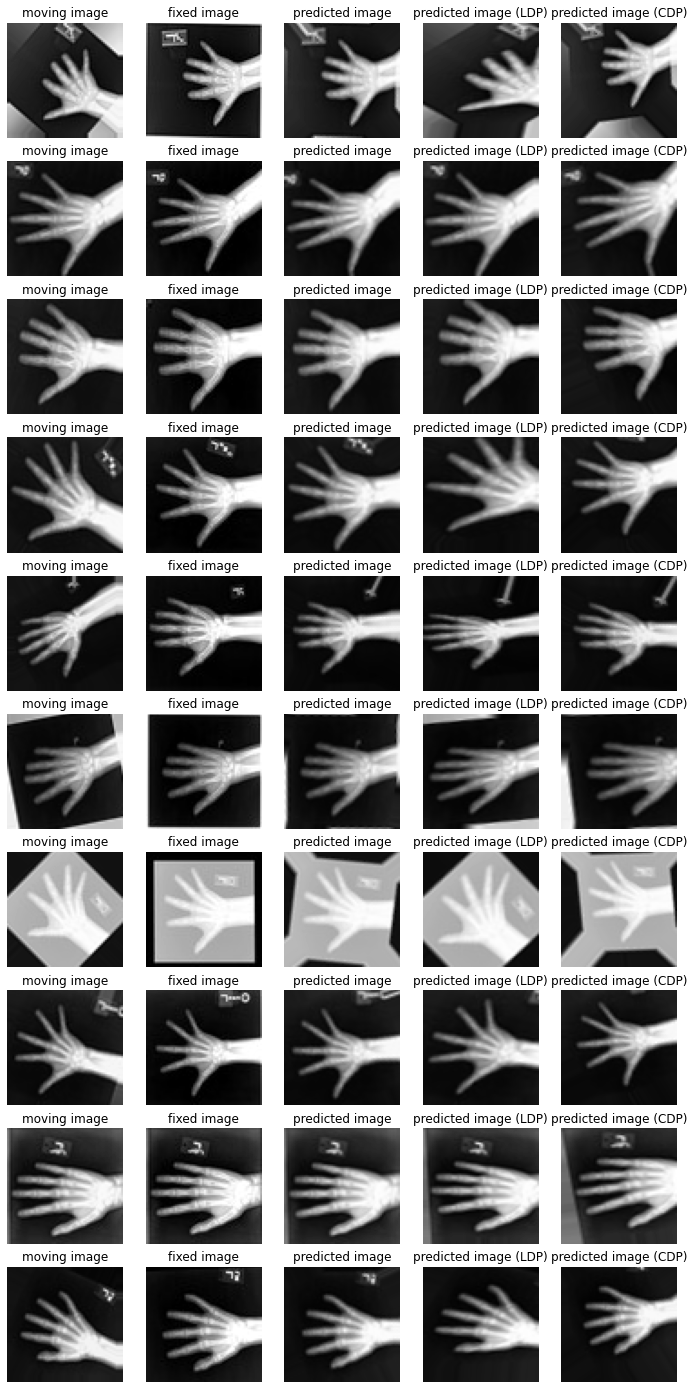

In [89]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()